# Modules et fonctions 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, f1_score

skf = StratifiedKFold(n_splits=5)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import shap

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.model_selection import RandomizedSearchCV


from sklearn.preprocessing import StandardScaler


from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Kernel de Kaggle disponible sur https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
from lightgbm_with_simple_features import *

In [70]:
" https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/_modules/numexpr/utils.html "

' https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/_modules/numexpr/utils.html '

In [4]:
import logging
log = logging.getLogger(__name__)

import os
import subprocess
import platform

from numexpr.interpreter import _set_num_threads, MAX_THREADS
from numexpr import use_vml

if use_vml:
    from numexpr.interpreter import (
        _get_vml_version, _set_vml_accuracy_mode, _set_vml_num_threads)


def get_vml_version():
    """Get the VML/MKL library version."""
    if use_vml:
        return _get_vml_version()
    else:
        return None



def set_vml_accuracy_mode(mode):
    """
    Set the accuracy mode for VML operations.

    The `mode` parameter can take the values:
    - 'high': high accuracy mode (HA), <1 least significant bit
    - 'low': low accuracy mode (LA), typically 1-2 least significant bits
    - 'fast': enhanced performance mode (EP)
    - None: mode settings are ignored

    This call is equivalent to the `vmlSetMode()` in the VML library.
    See:

    http://www.intel.com/software/products/mkl/docs/webhelp/vml/vml_DataTypesAccuracyModes.html

    for more info on the accuracy modes.

    Returns old accuracy settings.
    """
    if use_vml:
        acc_dict = {None: 0, 'low': 1, 'high': 2, 'fast': 3}
        acc_reverse_dict = {1: 'low', 2: 'high', 3: 'fast'}
        if mode not in list(acc_dict.keys()):
            raise ValueError(
                "mode argument must be one of: None, 'high', 'low', 'fast'")
        retval = _set_vml_accuracy_mode(acc_dict.get(mode, 0))
        return acc_reverse_dict.get(retval)
    else:
        return None



def set_vml_num_threads(nthreads):
    """
    Suggests a maximum number of threads to be used in VML operations.

    This function is equivalent to the call
    `mkl_domain_set_num_threads(nthreads, MKL_DOMAIN_VML)` in the MKL
    library.  See:

    http://www.intel.com/software/products/mkl/docs/webhelp/support/functn_mkl_domain_set_num_threads.html

    for more info about it.
    """
    if use_vml:
        _set_vml_num_threads(nthreads)



def set_num_threads(nthreads):
    """
    Sets a number of threads to be used in operations.

    Returns the previous setting for the number of threads.

    During initialization time Numexpr sets this number to the number
    of detected cores in the system (see `detect_number_of_cores()`).

    If you are using Intel's VML, you may want to use
    `set_vml_num_threads(nthreads)` to perform the parallel job with
    VML instead.  However, you should get very similar performance
    with VML-optimized functions, and VML's parallelizer cannot deal
    with common expresions like `(x+1)*(x-2)`, while Numexpr's one
    can.
    """
    old_nthreads = _set_num_threads(nthreads)
    return old_nthreads


def _init_num_threads():
    """
    Detects the environment variable 'NUMEXPR_MAX_THREADS' to set the threadpool 
    size, and if necessary the slightly redundant 'NUMEXPR_NUM_THREADS' or 
    'OMP_NUM_THREADS' env vars to set the initial number of threads used by 
    the virtual machine.
    """
    # Any platform-specific short-circuits
    if 'sparc' in platform.machine():
        log.warning('The number of threads have been set to 1 because problems related '
                  'to threading have been reported on some sparc machine. '
                  'The number of threads can be changed using the "set_num_threads" '
                  'function.')
        set_num_threads(1)
        return 1

    env_configured = False
    n_cores = detect_number_of_cores()
    if 'NUMEXPR_MAX_THREADS' in os.environ:
        # The user has configured NumExpr in the expected way, so suppress logs.
        env_configured = True
        n_cores = MAX_THREADS
    else:
        # The use has not set 'NUMEXPR_MAX_THREADS', so likely they have not 
        # configured NumExpr as desired, so we emit info logs.
        if n_cores > MAX_THREADS:
            log.info('Note: detected %d virtual cores but NumExpr set to maximum of %d, check "NUMEXPR_MAX_THREADS" environment variable.'%(n_cores, MAX_THREADS))
        if n_cores > 8:
            # The historical 'safety' limit.
            log.info('Note: NumExpr detected %d cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.'%n_cores)
            n_cores = 8

    # Now we check for 'NUMEXPR_NUM_THREADS' or 'OMP_NUM_THREADS' to set the 
    # actual number of threads used.
    if 'NUMEXPR_NUM_THREADS' in os.environ:
        requested_threads = int(os.environ['NUMEXPR_NUM_THREADS'])
    elif 'OMP_NUM_THREADS' in os.environ:
        requested_threads = int(os.environ['OMP_NUM_THREADS'])
    else:
        requested_threads = n_cores
        if not env_configured:
            log.info('NumExpr defaulting to %d threads.'%n_cores)

    # The C-extension function performs its own checks against `MAX_THREADS`
    set_num_threads(requested_threads)
    return requested_threads

    
def detect_number_of_cores():
    """
    Detects the number of cores on a system. Cribbed from pp.
    """
    # Linux, Unix and MacOS:
    if hasattr(os, "sysconf"):
        if "SC_NPROCESSORS_ONLN" in os.sysconf_names:
            # Linux & Unix:
            ncpus = os.sysconf("SC_NPROCESSORS_ONLN")
            if isinstance(ncpus, int) and ncpus > 0:
                return ncpus
        else:  # OSX:
            return int(subprocess.check_output(["sysctl", "-n", "hw.ncpu"]))
    # Windows:
    try:
        ncpus = int(os.environ.get("NUMBER_OF_PROCESSORS", ""))
        if ncpus > 0:
            return ncpus
    except ValueError:
        pass
    return 1  # Default



def detect_number_of_threads():
    """
    DEPRECATED: use `_init_num_threads` instead.
    If this is modified, please update the note in: https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide
    """
    log.warning('Deprecated, use `init_num_threads` instead.')
    try:
        nthreads = int(os.environ.get('NUMEXPR_NUM_THREADS', ''))
    except ValueError:
        try:
            nthreads = int(os.environ.get('OMP_NUM_THREADS', ''))
        except ValueError:
            nthreads = detect_number_of_cores()

    # Check that we don't surpass the MAX_THREADS in interpreter.cpp
    if nthreads > MAX_THREADS:
        nthreads = MAX_THREADS
    return nthreads



class CacheDict(dict):
    """
    A dictionary that prevents itself from growing too much.
    """

    def __init__(self, maxentries):
        self.maxentries = maxentries
        super(CacheDict, self).__init__(self)

    def __setitem__(self, key, value):
        # Protection against growing the cache too much
        if len(self) > self.maxentries:
            # Remove a 10% of (arbitrary) elements from the cache
            entries_to_remove = self.maxentries // 10
            for k in list(self.keys())[:entries_to_remove]:
                super(CacheDict, self).__delitem__(k)
        super(CacheDict, self).__setitem__(key, value)

In [5]:
detect_number_of_cores()

12

In [6]:
detect_number_of_threads()

Deprecated, use `init_num_threads` instead.


12

In [7]:
_init_num_threads()

8

In [8]:
set_num_threads(8)

8

# Les données 

In [2]:
with open('HomeCredit_columns_description.csv') as f:
    print(f)

<_io.TextIOWrapper name='HomeCredit_columns_description.csv' mode='r' encoding='cp1252'>


In [3]:
home_cred = pd.read_csv('HomeCredit_columns_description.csv', encoding ='cp1258')

In [4]:
home_cred

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [2]:
def taux_remp(df):
    return 1-df.isna().sum()/len(df)

## Chargement des données via le kernel

In [3]:
train_test = application_train_test(num_rows = None, nan_as_category = False)

In [4]:
train_test

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [5]:
bureau_balance = bureau_and_balance(num_rows = None, nan_as_category = True)

In [6]:
prev_appli = previous_applications(num_rows = None, nan_as_category = True)

In [7]:
poscash = pos_cash(num_rows = None, nan_as_category = True)

In [8]:
install_pay = installments_payments(num_rows = None, nan_as_category = True)

In [9]:
cre_card_bal = credit_card_balance(num_rows = None, nan_as_category = True)

## Séparation des données d'entrainement et test

In [5]:
train = train_test[train_test['TARGET'].notna()].drop(columns=['index', 'SK_ID_CURR'])
display(train)

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,0,1,0,1,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,0.0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,0,1,0,1,0,NaN,0.267112,72000.0,0.166687,0.044524
307508,0.0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,1,0,0,1,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,1.0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,0,1,0,1,0,0.400134,0.462029,85500.0,0.118158,0.054592


In [6]:
test = train_test[train_test['TARGET'].isna()].drop(columns=['index', 'SK_ID_CURR'])
display(test)

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
307511,NaN,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0,1,0,1,0,0.121044,0.237342,67500.0,0.152300,0.036147
307512,NaN,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,0,0.247398,0.444409,49500.0,0.175455,0.077973
307513,NaN,0,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,0,0.222477,0.305308,101250.0,0.344578,0.105202
307514,NaN,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,1,0,0,1,0,0.133515,0.200000,78750.0,0.155614,0.031123
307515,NaN,0,1,1,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,0,0.168021,0.287770,60000.0,0.178150,0.051266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,0.002042,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,0.035792,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,0.018850,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [47]:
train.to_csv('train.csv')
test.to_csv('test.csv')

## Taux de remplissage et Imputation

In [7]:
taux_remp(train)

TARGET                 1.000000
CODE_GENDER            1.000000
FLAG_OWN_CAR           1.000000
FLAG_OWN_REALTY        1.000000
CNT_CHILDREN           1.000000
                         ...   
DAYS_EMPLOYED_PERC     0.819926
INCOME_CREDIT_PERC     1.000000
INCOME_PER_PERSON      0.999993
ANNUITY_INCOME_PERC    0.999961
PAYMENT_RATE           0.999961
Length: 246, dtype: float64

In [8]:
train.dtypes

TARGET                 float64
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN             int64
                        ...   
DAYS_EMPLOYED_PERC     float64
INCOME_CREDIT_PERC     float64
INCOME_PER_PERSON      float64
ANNUITY_INCOME_PERC    float64
PAYMENT_RATE           float64
Length: 246, dtype: object

In [9]:
X = train.drop(columns=['TARGET']) 
y = train['TARGET']

In [10]:
taux_remp(X)

CODE_GENDER            1.000000
FLAG_OWN_CAR           1.000000
FLAG_OWN_REALTY        1.000000
CNT_CHILDREN           1.000000
AMT_INCOME_TOTAL       1.000000
                         ...   
DAYS_EMPLOYED_PERC     0.819926
INCOME_CREDIT_PERC     1.000000
INCOME_PER_PERSON      0.999993
ANNUITY_INCOME_PERC    0.999961
PAYMENT_RATE           0.999961
Length: 245, dtype: float64

In [11]:
y

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    1.0
307510    0.0
Name: TARGET, Length: 307507, dtype: float64

In [12]:
X.shape

(307507, 245)

In [13]:
X.mean()

CODE_GENDER                 0.658352
FLAG_OWN_CAR                0.340106
FLAG_OWN_REALTY             0.306331
CNT_CHILDREN                0.417047
AMT_INCOME_TOTAL       168797.685779
                           ...      
DAYS_EMPLOYED_PERC          0.156860
INCOME_CREDIT_PERC          0.399669
INCOME_PER_PERSON       93106.077361
ANNUITY_INCOME_PERC         0.180931
PAYMENT_RATE                0.053695
Length: 245, dtype: float64

In [14]:
X_fill = X.fillna(X.mean())

In [15]:
taux_remp(X_fill)

CODE_GENDER            1.0
FLAG_OWN_CAR           1.0
FLAG_OWN_REALTY        1.0
CNT_CHILDREN           1.0
AMT_INCOME_TOTAL       1.0
                      ... 
DAYS_EMPLOYED_PERC     1.0
INCOME_CREDIT_PERC     1.0
INCOME_PER_PERSON      1.0
ANNUITY_INCOME_PERC    1.0
PAYMENT_RATE           1.0
Length: 245, dtype: float64

## Train test split 

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_fill, y, test_size=0.3, random_state=3, stratify=y)

In [12]:
X_train.shape

(215254, 247)

In [13]:
X_val.shape

(92253, 247)

In [16]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_fill, y, test_size=0.2, random_state=3, stratify=y)

## Création d'oversampling avec Smote

In [28]:
sm = SMOTE(random_state=1)

In [36]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [37]:
scaler = StandardScaler()
X_scaled_res = scaler.fit_transform(X_train_res)

In [38]:
X_val = scaler.transform(X_val)

## Standardisation

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [18]:
X_val = scaler.transform(X_val)

In [17]:
scaler1 = StandardScaler()
X_scaled1 = scaler1.fit_transform(X_train1)

In [18]:
X_val1 = scaler1.transform(X_val1)

##  Création d'un sample

In [28]:
sample = train.sample(frac=0.1, random_state=1)

In [29]:
sample

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
292051,292051,438333,0.0,1,0,0,0,315000.0,252000.0,19908.0,...,0,0,0,0,0,0.105249,1.250000,157500.0,0.063200,0.079000
122561,122561,242095,0.0,1,1,0,0,135000.0,1042560.0,34587.0,...,0,0,0,0,0,0.198294,0.129489,67500.0,0.256200,0.033175
196022,196022,327296,0.0,1,1,0,1,180000.0,270000.0,13500.0,...,0,0,0,0,0,0.089519,0.666667,60000.0,0.075000,0.050000
114506,114506,232781,0.0,1,0,1,0,112500.0,728460.0,40675.5,...,1,0,0,1,0,0.138306,0.154435,56250.0,0.361560,0.055838
246632,246632,385427,0.0,1,0,0,0,112500.0,622413.0,30073.5,...,0,1,0,1,0,0.046042,0.180748,56250.0,0.267320,0.048318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307449,307449,456187,0.0,0,1,0,1,315000.0,1175314.5,38974.5,...,1,0,0,1,0,0.207545,0.268013,105000.0,0.123729,0.033161
250614,250614,389979,0.0,0,0,1,1,135000.0,161730.0,10741.5,...,1,0,0,1,0,0.011011,0.834725,45000.0,0.079567,0.066416
55661,55661,164490,0.0,1,1,0,0,292500.0,1800000.0,49500.0,...,1,0,0,1,0,0.456909,0.162500,146250.0,0.169231,0.027500
106001,106001,222988,1.0,1,0,0,0,135000.0,265500.0,18090.0,...,0,0,0,0,0,0.074158,0.508475,135000.0,0.134000,0.068136


In [35]:
X_s = sample.drop(columns=['TARGET'])
y_s = sample['TARGET']

X_s_fill = X_s.fillna(X_s.mean())

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_s_fill, y_s, test_size=0.3, random_state= 1, stratify=y_s)

In [36]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_s)

In [37]:
X_val_s = scaler.transform(X_val_s)

# Test de modèle de classification sur un échantillon

Nous allons tester tous nos modèles sur notre sample et ne sélectionner que les 2 à 4 plus performants avant de tester sur le dataset complet.

In [38]:
comparatif_sample = pd.DataFrame()

## Regression logistique

### Paramètres par défaut 

In [43]:
log_reg = LogisticRegression(max_iter=300, random_state=1)

In [44]:
start_time = time.time()

log_reg.fit(X_train_s, y_train_s)

temp_fit_log = time.time()-start_time

In [45]:
start_time = time.time()

y_pred_log = log_reg.predict(X_val_s)

temp_pred_log = time.time()-start_time

y_prob_reg = log_reg.predict_proba(X_val_s)[:,1]

In [46]:
y_prob_reg

array([0.11260652, 0.0200031 , 0.03578104, ..., 0.05656777, 0.03901321,
       0.02700672])

In [47]:
log_reg.score(X_val_s, y_val_s)

0.9204422284847171

In [43]:
y_pred_log

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
acc_log = accuracy_score(y_pred_log, y_val_s)

In [49]:
auc_log = roc_auc_score(y_val_s, y_prob_reg)

In [50]:
dico_log = {'modèle': 'reg_log', 'fit': temp_fit_log, 'pred': temp_pred_log,
            'acc': acc_log, 'auc': auc_log}

In [51]:
comparatif_sample = comparatif_sample.append(dico_log, ignore_index=True)

In [52]:
comparatif_sample

,acc,auc,fit,modèle,pred
0,0.920442,0.73582,1.776184,reg_log,0.004001


### Gridsearch

In [53]:
params_reg = {'penalty':['l1', 'l2', 'elasticnet'], 'C':np.logspace(-3,3,7)}

In [54]:
log_reg = LogisticRegression(max_iter=300, random_state=1)

In [55]:
log_reg_cv = GridSearchCV(log_reg, params_reg, cv=skf, scoring='roc_auc')

In [56]:
log_reg_cv.fit(X_train_s, y_train_s)

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validati

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validati

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=300, random_state=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='roc_auc')

In [57]:
pd.DataFrame(log_reg_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014002,0.001789,0.000000,0.000000e+00,0.001,l1,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,0.133513,0.004836,0.003201,3.999715e-04,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.734793,0.724448,0.741533,0.739287,0.737108,0.735434,0.005932,1
2,0.014190,0.000407,0.000000,0.000000e+00,0.001,elasticnet,"{'C': 0.001, 'penalty': 'elasticnet'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
3,0.013703,0.001165,0.000000,0.000000e+00,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
4,0.272080,0.010523,0.002801,4.000903e-04,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.733272,0.723306,0.734303,0.737994,0.738944,0.733564,0.005558,2
5,0.011203,0.001166,0.000000,0.000000e+00,0.01,elasticnet,"{'C': 0.01, 'penalty': 'elasticnet'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
6,0.013704,0.000400,0.000000,0.000000e+00,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
7,0.595006,0.027618,0.003001,2.431402e-07,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.731673,0.721198,0.730953,0.738678,0.734705,0.731441,0.005801,3
8,0.015006,0.001548,0.000000,0.000000e+00,0.1,elasticnet,"{'C': 0.1, 'penalty': 'elasticnet'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
9,0.013803,0.000400,0.000000,0.000000e+00,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,14


In [58]:
log_reg_cv.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [59]:
log_reg_cv.best_score_

0.7354339008956764

In [60]:
log_reg_2 = LogisticRegression(max_iter=300, C=0.001, penalty='l2', random_state=1)

In [61]:
cross_val_score(log_reg_2, X_train_s, y_train_s, cv=skf, scoring='roc_auc')

array([0.73479294, 0.72444837, 0.74153327, 0.73928714, 0.73710778])

In [62]:
start_time = time.time()

log_reg_2.fit(X_train_s, y_train_s)

temp_fit_log2 = time.time()-start_time

In [63]:
start_time = time.time()

y_pred_reg2 = log_reg_2.predict(X_val_s)

temp_pred_log2 = time.time()-start_time

y_prob_reg2 = log_reg_2.predict_proba(X_val_s)[:,1]

In [64]:
acc_cv_reg = accuracy_score(y_pred_reg2, y_val_s)
print(acc_cv_reg)

0.921092564491654


In [65]:
auc_cv_reg = roc_auc_score(y_val_s, y_prob_reg2)
print(auc_cv_reg)

0.7328159308331114


In [66]:
dico_log = {'modèle': 'reg_log_cv', 'fit': temp_fit_log2, 'pred': temp_pred_log2,
            'acc': acc_cv_reg, 'auc': auc_cv_reg}


comparatif_sample = comparatif_sample.append(dico_log, ignore_index=True)

## SVM

### Paramètres par défaut

In [67]:
svc = SVC(random_state=1)

In [68]:
start_time = time.time()

svc.fit(X_train_s, y_train_s)

temp_fit_svc = time.time()-start_time

In [69]:
# Avec proba=True, SVC permet de calculer le predict_proba mais le modèle est trop long

start_time = time.time()

y_pred_svc = svc.predict(X_val_s)

temp_pred_svc = time.time()-start_time

#y_prob_svc = svc.predict_proba(X_val_s)

In [70]:
acc_svc = accuracy_score(y_pred_svc, y_val_s)
print(acc_svc)

0.921092564491654


In [71]:
dico_svc = {'modèle': 'svc', 'fit':temp_fit_svc, 'pred': temp_pred_svc, 'acc': acc_svc}

In [72]:
comparatif_sample = comparatif_sample.append(dico_svc, ignore_index=True)

In [73]:
comparatif_sample

,acc,auc,fit,modèle,pred
0,0.920442,0.735820,1.776184,reg_log,0.004001
1,0.921093,0.732816,0.159681,reg_log_cv,0.004000
2,0.921093,NaN,139.626045,svc,16.417820


 Le temps d'apprentissage est très long, suivant la remarque : $\newline$
"The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using LinearSVC or SGDClassifier instead, possibly after a Nystroem transformer." $\newline$
Voir : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

## SGDClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

### Paramètre par défaut

In [77]:
sgdc = SGDClassifier(loss='modified_huber', random_state=1)

In [78]:
start_time = time.time()

sgdc.fit(X_train_s, y_train_s)

temp_fit_sgdc = time.time()-start_time


start_time = time.time()

y_pred_sgdc = sgdc.predict(X_val_s)

temp_pred_sgdc = time.time()-start_time

y_prob_sgdc = sgdc.predict_proba(X_val_s)[:,1]

In [79]:
acc_sgdc = accuracy_score(y_pred_sgdc, y_val_s)
print(acc_sgdc)

auc_sgdc = roc_auc_score(y_val_s, y_prob_sgdc)
print(auc_sgdc)

0.8743767613266854
0.5951544190100321


In [80]:
dico_sgdc = {'modèle': 'sgdc', 'fit': temp_fit_sgdc, 'pred': temp_pred_sgdc,
             'acc': acc_sgdc, 'auc': auc_sgdc}


comparatif_sample = comparatif_sample.append(dico_log, ignore_index=True)

### GridSearch

In [81]:
params_sgdc = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

sgdc1 = SGDClassifier(max_iter=1000, random_state=1, tol=1e-2) # tol=1e-2 ou -1, normalement max_iter à 1000
sgdc_cv = GridSearchCV(sgdc1, param_grid=params_sgdc, scoring='roc_auc', cv=skf)

In [82]:
sgdc_cv.fit(X_train_s, y_train_s)

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(random_state=1, tol=0.01),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'penalty': ['l2', 'l1', 'none']},
             scoring='roc_auc')

In [83]:
sgdc_cv.best_params_

{'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}

In [84]:
sgdc_cv2 = SGDClassifier(alpha=0.01, loss='log', penalty='l2', max_iter=1000, random_state=1)

In [85]:
cross_val_score(sgdc_cv2, X_train_s, y_train_s, cv=skf, scoring='roc_auc')

array([0.7282387 , 0.71425628, 0.7249618 , 0.73329797, 0.73372153])

In [86]:
start_time = time.time()

sgdc_cv2.fit(X_train_s, y_train_s)

temp_fit_sgdc_cv = time.time()-start_time

In [87]:
start_time = time.time()

y_pred_sgdc_cv = sgdc_cv2.predict(X_val_s)

temp_pred_sgdc_cv = time.time()-start_time

y_prob_sgdc_cv = sgdc_cv2.predict_proba(X_val_s)[:,1]

In [88]:
acc_cv_sgdc = accuracy_score(y_pred_sgdc_cv, y_val_s)
print(acc_cv_sgdc)



auc_cv_sgdc = roc_auc_score(y_val_s, y_prob_sgdc_cv)
print(auc_cv_sgdc)

0.9200086711467591
0.7314783504328103


In [89]:
dico_sgdc_cv = {'modèle': 'sgdc_cv', 'fit': temp_fit_sgdc_cv, 'pred': temp_pred_sgdc_cv,
            'acc': acc_cv_sgdc, 'auc': auc_cv_sgdc}

In [90]:
comparatif_sample = comparatif_sample.append(dico_sgdc_cv, ignore_index=True)

## KNN

### Modèle de base : recherche de l'erreur minimale

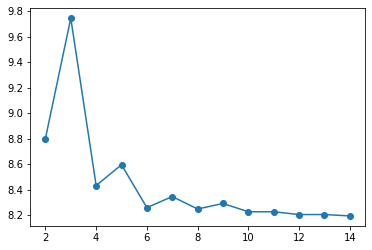

In [199]:
errors = []
for k in range(2,15):
    knn = KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train_s, y_train_s).score(X_val_s, y_val_s)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

On va prendre k=14 puis l'erreur semble stableà partir de k=10.

In [201]:
knn = KNeighborsClassifier(14)

In [202]:
start_time = time.time()

knn.fit(X_train_s, y_train_s)

temp_fit_knn = time.time()-start_time

In [203]:
start_time = time.time()

y_pred_knn = knn.predict(X_val_s)

temp_pred_knn = time.time()-start_time

In [204]:
acc_knn = accuracy_score(y_pred_knn, y_val_s)
print(acc_knn)

auc_knn = roc_auc_score(y_val_s, y_pred_knn)
print(auc_knn)

0.9180576631259484
0.5


In [205]:
dico_knn = {'modèle': 'knn', 'fit':temp_fit_knn, 'pred': temp_pred_knn, 'acc': acc_knn, 'auc': auc_knn}

In [206]:
comparatif_sample = comparatif_sample.append(dico_knn, ignore_index=True)

Si l'accuracy est bonne, l'auc est trop bas. Pas besoin d'un gridsearch, on passe au modèle suivant !

## Arbres de décision

In [104]:
tree = DecisionTreeClassifier(random_state=1)

In [105]:
start_time = time.time()

tree.fit(X_train_s, y_train_s)

temp_fit_tree = time.time()-start_time

In [106]:
start_time = time.time()

y_pred_tree = tree.predict(X_val_s)

temp_pred_tree = time.time()-start_time

y_prob_tree = tree.predict_proba(X_val_s)[:,1]

In [107]:
acc_tree = accuracy_score(y_pred_tree, y_val_s)
print(acc_tree)

auc_tree = roc_auc_score(y_val_s, y_prob_tree)
print(auc_tree)

0.8483633210492088
0.5291675318546484


In [108]:
dico_tree = {'modèle': 'tree', 'fit': temp_fit_tree, 'pred': temp_pred_tree,
             'acc': acc_tree, 'auc': auc_tree}

In [109]:
comparatif_sample = comparatif_sample.append(dico_tree, ignore_index=True)

In [120]:
tree.feature_importances_

array([2.62326448e-02, 2.59389822e-02, 2.72442136e-03, 3.05255610e-03,
       1.48190869e-03, 4.37700530e-03, 1.76291671e-02, 1.71580085e-02,
       2.41364337e-02, 1.17002221e-02, 2.74306959e-02, 2.65973900e-02,
       3.12659188e-02, 3.28511324e-02, 3.89899229e-02, 1.49321820e-02,
       0.00000000e+00, 8.91820673e-04, 2.34396389e-03, 0.00000000e+00,
       3.28115689e-03, 1.03364227e-03, 4.49631421e-03, 2.27979660e-03,
       4.44888023e-03, 1.75224586e-02, 6.83962507e-04, 1.76769259e-03,
       8.46233312e-04, 1.24765312e-03, 5.82663624e-03, 4.40671263e-03,
       2.66781854e-02, 5.00682629e-02, 6.13339984e-02, 3.24492215e-03,
       2.65655561e-03, 3.23646655e-03, 3.29954492e-03, 1.62108237e-03,
       0.00000000e+00, 4.04099408e-03, 9.30808018e-04, 2.35199922e-03,
       6.78803144e-04, 4.68669279e-03, 4.35010032e-03, 3.02808522e-03,
       3.94431683e-03, 3.61841629e-03, 6.49236057e-03, 3.63045332e-03,
       3.23093632e-03, 3.40399309e-03, 9.36411707e-04, 1.57830308e-03,
      

Feature: 0, Score: 0.01921
Feature: 1, Score: 0.02288
Feature: 2, Score: 0.00463
Feature: 3, Score: 0.00311
Feature: 4, Score: 0.00564
Feature: 5, Score: 0.00474
Feature: 6, Score: 0.01104
Feature: 7, Score: 0.01437
Feature: 8, Score: 0.02731
Feature: 9, Score: 0.01540
Feature: 10, Score: 0.02599
Feature: 11, Score: 0.03789
Feature: 12, Score: 0.02237
Feature: 13, Score: 0.03428
Feature: 14, Score: 0.03878
Feature: 15, Score: 0.01184
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00136
Feature: 18, Score: 0.00126
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00223
Feature: 21, Score: 0.00201
Feature: 22, Score: 0.00910
Feature: 23, Score: 0.00322
Feature: 24, Score: 0.00307
Feature: 25, Score: 0.01536
Feature: 26, Score: 0.00094
Feature: 27, Score: 0.00091
Feature: 28, Score: 0.00157
Feature: 29, Score: 0.00279
Feature: 30, Score: 0.00170
Feature: 31, Score: 0.00193
Feature: 32, Score: 0.02003
Feature: 33, Score: 0.06426
Feature: 34, Score: 0.05171
Feature: 35, Score: 0.00416
Fe

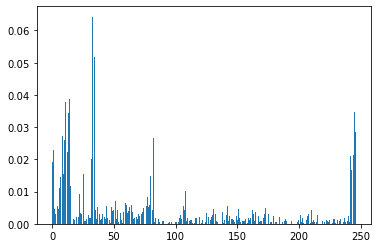

In [110]:
importance = tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Forêts aléatoires

### Paramètres par défaut

In [91]:
forest = RandomForestClassifier(random_state=1)

In [92]:
start_time = time.time()

forest.fit(X_train_s, y_train_s)

temp_fit_forest = time.time()-start_time

In [93]:
start_time = time.time()

y_pred_forest = forest.predict(X_val_s)

temp_pred_forest = time.time()-start_time

In [94]:
y_prob_for = forest.predict_proba(X_val_s)[:,1]

In [95]:
acc_forest = accuracy_score(y_pred_forest, y_val_s)
print(acc_forest)

auc_forest = roc_auc_score(y_val_s, y_prob_for)
print(auc_forest)

0.921092564491654
0.6813360577408


In [96]:
dico_forest = {'modèle': 'forest', 'fit':temp_fit_forest, 'pred': temp_pred_forest, 'acc': acc_forest, 'auc': auc_forest}

In [97]:
comparatif_sample = comparatif_sample.append(dico_forest, ignore_index=True)

In [98]:
comparatif_sample

,acc,auc,fit,modèle,pred
0,0.920442,0.735820,1.776184,reg_log,0.004001
1,0.921093,0.732816,0.159681,reg_log_cv,0.004000
2,0.921093,NaN,139.626045,svc,16.417820
3,0.921093,0.732816,0.159681,reg_log_cv,0.004000
4,0.920009,0.731478,0.516893,sgdc_cv,0.004000
5,0.921093,0.681336,6.356423,forest,0.188049


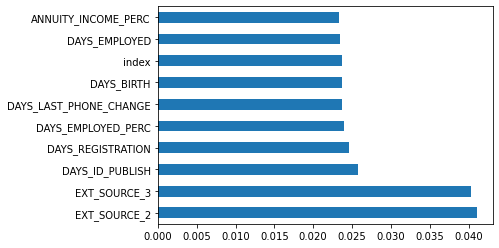

In [99]:
#print(forest.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Gridsearch

In [100]:
params_forest = {"max_depth":[3,5,7,9], 'min_samples_leaf':[1, 2, 3, 5]}

In [101]:
grid_forest = GridSearchCV(RandomForestClassifier(), params_forest, scoring="roc_auc", cv=skf)

In [102]:
grid_forest.fit(X_train_s, y_train_s)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 3, 5]},
             scoring='roc_auc')

In [103]:
pd.DataFrame(grid_forest.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.067427,0.012130,0.027248,3.876528e-04,3,1,"{'max_depth': 3, 'min_samples_leaf': 1}",0.705361,0.706026,0.738427,0.716166,0.705228,0.714242,0.012777,16
1,1.064165,0.016739,0.027406,4.898235e-04,3,2,"{'max_depth': 3, 'min_samples_leaf': 2}",0.712535,0.699559,0.742402,0.727372,0.707930,0.717960,0.015196,13
2,1.080242,0.047995,0.027006,8.176054e-07,3,3,"{'max_depth': 3, 'min_samples_leaf': 3}",0.711716,0.703965,0.737292,0.721900,0.717215,0.718418,0.011168,12
3,1.067238,0.014916,0.027407,4.900377e-04,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",0.716726,0.700671,0.733908,0.718921,0.713989,0.716843,0.010632,15
4,1.540445,0.018627,0.032007,5.642013e-07,5,1,"{'max_depth': 5, 'min_samples_leaf': 1}",0.715580,0.713835,0.741846,0.731501,0.717700,0.724092,0.010850,7
5,1.538542,0.007073,0.032511,6.263218e-04,5,2,"{'max_depth': 5, 'min_samples_leaf': 2}",0.716566,0.707744,0.746307,0.732814,0.718765,0.724439,0.013574,5
6,1.539944,0.017641,0.032807,3.999473e-04,5,3,"{'max_depth': 5, 'min_samples_leaf': 3}",0.714415,0.706190,0.742377,0.733851,0.715292,0.722425,0.013470,8
7,1.532943,0.014978,0.032408,4.903106e-04,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.719619,0.705564,0.742720,0.726620,0.714431,0.721791,0.012518,9
8,1.990977,0.024879,0.037809,7.483538e-04,7,1,"{'max_depth': 7, 'min_samples_leaf': 1}",0.715322,0.703194,0.739981,0.730809,0.717476,0.721356,0.012787,10
9,2.009188,0.008831,0.038008,3.162980e-07,7,2,"{'max_depth': 7, 'min_samples_leaf': 2}",0.722137,0.717983,0.750932,0.729760,0.713174,0.726797,0.013238,1


In [104]:
grid_forest.best_params_

{'max_depth': 7, 'min_samples_leaf': 2}

In [105]:
forest_cv = RandomForestClassifier(max_depth=7, min_samples_leaf=2, random_state=1)

In [106]:
cross_val_score(forest_cv, X_train_s, y_train_s, cv=skf, scoring='roc_auc')

array([0.71340465, 0.7114775 , 0.73934649, 0.72754024, 0.71792004])

In [107]:
start_time = time.time()

forest_cv.fit(X_train_s, y_train_s)

temp_fit_forest_cv = time.time()-start_time

In [108]:
start_time = time.time()

y_pred_forest_cv = forest_cv.predict(X_val_s)

temp_pred_forest_cv = time.time()-start_time

y_prob_forest_cv = forest_cv.predict_proba(X_val_s)[:,1]

In [109]:
acc_cv_forest = accuracy_score(y_pred_forest_cv, y_val_s)
print(acc_cv_forest)



auc_cv_forest = roc_auc_score(y_val_s, y_prob_forest_cv)
print(auc_cv_forest)

0.921092564491654
0.7174595379908395


In [110]:
dico_forest_cv = {'modèle': 'forest_cv', 'fit': temp_fit_forest_cv, 'pred': temp_pred_forest_cv,
            'acc': acc_cv_forest, 'auc': auc_cv_forest}

In [111]:
comparatif_sample = comparatif_sample.append(dico_forest_cv, ignore_index=True)

In [112]:
comparatif_sample

,acc,auc,fit,modèle,pred
0,0.920442,0.735820,1.776184,reg_log,0.004001
1,0.921093,0.732816,0.159681,reg_log_cv,0.004000
2,0.921093,NaN,139.626045,svc,16.417820
3,0.921093,0.732816,0.159681,reg_log_cv,0.004000
4,0.920009,0.731478,0.516893,sgdc_cv,0.004000
5,0.921093,0.681336,6.356423,forest,0.188049
6,0.921093,0.717460,2.401438,forest_cv,0.071015


## Gradient Boosting Maching

### Paramètres par défaut

In [113]:
gbc = GradientBoostingClassifier(random_state=1)

In [114]:
start_time = time.time()

gbc.fit(X_train_s, y_train_s)

temp_fit_gbc = time.time()-start_time

In [115]:
start_time = time.time()

y_pred_gbc = gbc.predict(X_val_s)

temp_pred_gbc = time.time()-start_time

y_prob_gbc = gbc.predict_proba(X_val_s)[:,1]

In [116]:
acc_gbc = accuracy_score(y_pred_gbc, y_val_s)
print(acc_gbc)

auc_gbc = roc_auc_score(y_val_s, y_prob_gbc)
print(auc_gbc)

0.9200086711467591
0.748983762178043


In [117]:
dico_gbc = {'modèle': 'gbc', 'fit':temp_fit_gbc, 'pred': temp_pred_gbc, 'acc': acc_gbc, 'auc': auc_gbc}

In [118]:
comparatif_sample = comparatif_sample.append(dico_gbc, ignore_index=True)

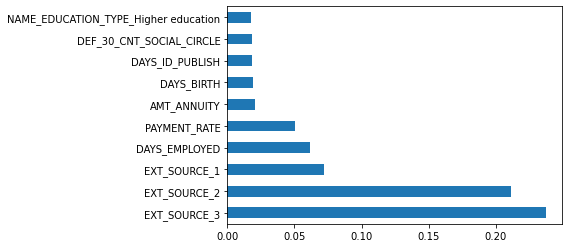

In [119]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(gbc.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Gridsearch

In [120]:
params_gbc = {"loss":['deviance', 'exponential'], 'min_samples_split':[2,3,5,7], 'min_samples_leaf':[1, 2, 3, 5]}

In [121]:
grid_gbc = GridSearchCV(GradientBoostingClassifier(), params_gbc, scoring="roc_auc", cv=skf)

In [122]:
grid_gbc.fit(X_train_s, y_train_s)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(),
             param_grid={'loss': ['deviance', 'exponential'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [2, 3, 5, 7]},
             scoring='roc_auc')

In [123]:
pd.DataFrame(grid_gbc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.574295,0.216134,0.009202,4.003287e-04,deviance,1,2,"{'loss': 'deviance', 'min_samples_leaf': 1, 'm...",0.739962,0.739006,0.757902,0.748666,0.751421,0.747392,0.007125,25
1,18.647701,0.263063,0.009202,4.002096e-04,deviance,1,3,"{'loss': 'deviance', 'min_samples_leaf': 1, 'm...",0.742998,0.740313,0.758751,0.748255,0.750791,0.748221,0.006439,22
2,19.680650,0.436694,0.009608,5.048370e-04,deviance,1,5,"{'loss': 'deviance', 'min_samples_leaf': 1, 'm...",0.742458,0.738435,0.753850,0.749290,0.748612,0.746529,0.005434,32
3,19.571316,0.086716,0.009277,9.159976e-04,deviance,1,7,"{'loss': 'deviance', 'min_samples_leaf': 1, 'm...",0.740902,0.739392,0.754905,0.748400,0.754983,0.747716,0.006644,24
4,19.590217,0.137641,0.009438,4.767948e-04,deviance,2,2,"{'loss': 'deviance', 'min_samples_leaf': 2, 'm...",0.745245,0.740206,0.750850,0.748985,0.751406,0.747339,0.004168,26
5,20.126191,0.358702,0.009555,4.968579e-04,deviance,2,3,"{'loss': 'deviance', 'min_samples_leaf': 2, 'm...",0.744594,0.740016,0.750710,0.748867,0.751002,0.747038,0.004191,29
6,20.138309,0.394654,0.009473,4.720769e-04,deviance,2,5,"{'loss': 'deviance', 'min_samples_leaf': 2, 'm...",0.743192,0.739038,0.751681,0.751296,0.750723,0.747186,0.005137,27
7,19.688606,0.104736,0.009136,6.674945e-04,deviance,2,7,"{'loss': 'deviance', 'min_samples_leaf': 2, 'm...",0.744180,0.739893,0.752151,0.752891,0.752766,0.748376,0.005357,17
8,20.165073,0.584999,0.009435,7.615573e-04,deviance,3,2,"{'loss': 'deviance', 'min_samples_leaf': 3, 'm...",0.742728,0.740471,0.751475,0.750680,0.749811,0.747033,0.004524,30
9,19.699144,0.392822,0.010479,1.057369e-03,deviance,3,3,"{'loss': 'deviance', 'min_samples_leaf': 3, 'm...",0.742203,0.740446,0.751441,0.750557,0.749811,0.746892,0.004608,31


In [124]:
grid_gbc.best_params_

{'loss': 'exponential', 'min_samples_leaf': 2, 'min_samples_split': 7}

In [125]:
gbc_cv = GradientBoostingClassifier(loss='exponential', min_samples_leaf=2, min_samples_split=7,random_state=1)

In [126]:
start_time = time.time()

gbc_cv.fit(X_train_s, y_train_s)

temp_fit_gbc_cv = time.time()-start_time

In [127]:
start_time = time.time()

y_pred_gbc_cv = gbc_cv.predict(X_val_s)

temp_pred_gbc_cv = time.time()-start_time

y_prob_gbc_cv = gbc_cv.predict_proba(X_val_s)[:,1]

In [128]:
acc_cv_gbc = accuracy_score(y_pred_gbc_cv, y_val_s)
print(acc_cv_gbc)



auc_cv_gbc = roc_auc_score(y_val_s, y_prob_gbc_cv)
print(auc_cv_gbc)

0.920875785822675
0.7491610825042221


In [129]:
dico_gbc_cv = {'modèle': 'gbc_cv', 'fit': temp_fit_gbc_cv, 'pred': temp_pred_gbc_cv,
            'acc': acc_cv_gbc, 'auc': auc_cv_gbc}

In [130]:
comparatif_sample = comparatif_sample.append(dico_gbc_cv, ignore_index=True)

## Bayésien Naïf 

In [131]:
bayes = GaussianNB()

In [132]:
start_time = time.time()

bayes.fit(X_train_s, y_train_s)

temp_fit_bayes = time.time()-start_time

In [133]:
start_time = time.time()

y_pred_bayes = bayes.predict(X_val_s)

temp_pred_bayes = time.time()-start_time

In [134]:
y_prob_bayes = bayes.predict_proba(X_val_s)[:,1]

In [135]:
acc_bayes = accuracy_score(y_pred_bayes, y_val_s)
print(acc_bayes)

auc_bayes = roc_auc_score(y_val_s, y_prob_bayes)
print(auc_bayes)

0.10806416648601777
0.5084606203398861


In [136]:
dico_bayes = {'modèle': 'bayes', 'fit':temp_fit_bayes, 'pred': temp_pred_bayes, 'acc': acc_bayes, 'auc': auc_bayes}

In [137]:
comparatif_sample = comparatif_sample.append(dico_bayes, ignore_index=True)

## Perceptron multicouches

### Paramètres par défaut

In [138]:
mlpc = MLPClassifier(random_state=1)

In [139]:
start_time = time.time()

mlpc.fit(X_train_s, y_train_s)

temp_fit_mlpc = time.time()-start_time

In [140]:
start_time = time.time()

y_pred_mlpc = mlpc.predict(X_val_s)

temp_pred_mlpc = time.time()-start_time

In [141]:
y_prob_mlpc = mlpc.predict_proba(X_val_s)[:,1]

In [142]:
acc_mlpc = accuracy_score(y_pred_mlpc, y_val_s)
print(acc_mlpc)

auc_mlpc = roc_auc_score(y_val_s, y_prob_mlpc)
print(auc_mlpc)

0.8833730760893128
0.632868043935354


In [143]:
dico_mlpc = {'modèle': 'mlpc', 'fit':temp_fit_mlpc, 'pred': temp_pred_mlpc, 'acc': acc_mlpc, 'auc': auc_mlpc}

In [144]:
comparatif_sample = comparatif_sample.append(dico_mlpc, ignore_index=True)

### Gridsearch

In [145]:
params_mlpc = {'activation': ['tanh', 'relu'], 'solver': [
     'sgd', 'adam'], 'batch_size': [256, 512]}

In [146]:
grid_mlpc = GridSearchCV(MLPClassifier(random_state=1, max_iter=300), params_mlpc, scoring="roc_auc", cv=skf)

In [147]:
grid_mlpc.fit(X_train_s, y_train_s)

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
Stochastic Optimizer

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MLPClassifier(max_iter=300, random_state=1),
             param_grid={'activation': ['tanh', 'relu'],
                         'batch_size': [256, 512], 'solver': ['sgd', 'adam']},
             scoring='roc_auc')

In [148]:
pd.DataFrame(grid_mlpc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,27.906916,0.150830,0.013637,0.001065,tanh,256,sgd,"{'activation': 'tanh', 'batch_size': 256, 'sol...",0.703814,0.689944,0.698309,0.717083,0.694592,0.700748,0.009346,3
1,14.756515,1.835740,0.015720,0.001197,tanh,256,adam,"{'activation': 'tanh', 'batch_size': 256, 'sol...",0.639783,0.610529,0.626876,0.640406,0.652884,0.634096,0.014371,5
2,10.902451,0.391583,0.013461,0.001423,tanh,512,sgd,"{'activation': 'tanh', 'batch_size': 512, 'sol...",0.721338,0.707834,0.718349,0.725661,0.719275,0.718491,0.005894,1
3,13.668516,0.161378,0.014897,0.001123,tanh,512,adam,"{'activation': 'tanh', 'batch_size': 512, 'sol...",0.649703,0.605406,0.631581,0.630476,0.640587,0.631551,0.014804,6
4,25.370044,0.327757,0.009007,0.000888,relu,256,sgd,"{'activation': 'relu', 'batch_size': 256, 'sol...",0.679840,0.686419,0.687135,0.705373,0.692301,0.690213,0.008552,4
5,13.402401,0.960314,0.010350,0.000541,relu,256,adam,"{'activation': 'relu', 'batch_size': 256, 'sol...",0.610908,0.631005,0.607295,0.625484,0.636178,0.622174,0.011255,7
6,21.227600,0.662793,0.009602,0.000490,relu,512,sgd,"{'activation': 'relu', 'batch_size': 512, 'sol...",0.705504,0.708024,0.710294,0.720583,0.709182,0.710717,0.005183,2
7,13.992692,0.357271,0.009002,0.000633,relu,512,adam,"{'activation': 'relu', 'batch_size': 512, 'sol...",0.610155,0.615134,0.605279,0.632116,0.641053,0.620747,0.013598,8


In [149]:
grid_mlpc.best_params_

{'activation': 'tanh', 'batch_size': 512, 'solver': 'sgd'}

In [150]:
mlpc_cv = MLPClassifier(activation='tanh', batch_size=512, solver='sgd',random_state=1)

In [151]:
start_time = time.time()

mlpc_cv.fit(X_train_s, y_train_s)

temp_fit_mlpc_cv = time.time()-start_time

In [152]:
start_time = time.time()

y_pred_mlpc_cv = mlpc_cv.predict(X_val_s)

temp_pred_mlpc_cv = time.time()-start_time

y_prob_mlpc_cv = mlpc_cv.predict_proba(X_val_s)[:,1]

In [153]:
acc_cv_mlpc = accuracy_score(y_pred_mlpc_cv, y_val_s)
print(acc_cv_mlpc)



auc_cv_mlpc = roc_auc_score(y_val_s, y_prob_mlpc_cv)
print(auc_cv_mlpc)

0.9207673964881855
0.7202328149609862


In [154]:
dico_mlpc_cv = {'modèle': 'mlpc_cv', 'fit': temp_fit_mlpc_cv, 'pred': temp_pred_mlpc_cv,
            'acc': acc_cv_mlpc, 'auc': auc_cv_mlpc}

In [155]:
comparatif_sample = comparatif_sample.append(dico_mlpc_cv, ignore_index=True)

## DummyClassifier

In [156]:
dummy = DummyClassifier(strategy='most_frequent')

In [157]:
start_time = time.time()

dummy.fit(X_train_s, y_train_s)

temp_fit_dummy = time.time()-start_time

In [158]:
start_time = time.time()

y_pred_dummy = dummy.predict(X_val_s)

temp_pred_dummy = time.time()-start_time

In [159]:
y_prob_dum = dummy.predict_proba(X_val_s)[:,1]

In [160]:
acc_dummy = accuracy_score(y_pred_dummy, y_val_s)
print(acc_dummy)

auc_dummy = roc_auc_score(y_val_s, y_prob_dum)
print(auc_dummy)

0.921092564491654
0.5


In [161]:
dico_dummy = {'modèle': 'dummy', 'fit':temp_fit_dummy, 'pred': temp_pred_dummy, 'acc': acc_dummy, 'auc': auc_dummy}

In [162]:
comparatif_sample = comparatif_sample.append(dico_dummy, ignore_index=True)

## LightGBM

### Paramètres par défaut

In [163]:
lgbm = LGBMClassifier()

In [164]:
start_time = time.time()

lgbm.fit(X_train_s, y_train_s)

temp_fit_lgbm = time.time()-start_time

In [165]:
start_time = time.time()

y_pred_lgbm = lgbm.predict(X_val_s)

temp_pred_lgbm = time.time()-start_time

y_prob_lgbm = lgbm.predict_proba(X_val_s)[:,1]

In [166]:
acc_lgbm = accuracy_score(y_pred_lgbm, y_val_s)
print(acc_lgbm)

auc_lgbm = roc_auc_score(y_val_s, y_prob_lgbm)
print(auc_lgbm)

0.9190331671363537
0.738185164447226


In [167]:
dico_lgbm = {'modèle': 'lgbm', 'fit': temp_fit_lgbm, 'pred': temp_pred_lgbm,
                'acc': acc_lgbm, 'auc': auc_lgbm}


comparatif_sample = comparatif_sample.append(dico_lgbm, ignore_index=True)

In [168]:

cm = confusion_matrix(y_val_s, y_pred_lgbm)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[8468   30]
 [ 717   11]]

True Positives(TP) =  8468

True Negatives(TN) =  11

False Positives(FP) =  30

False Negatives(FN) =  717


<AxesSubplot:>

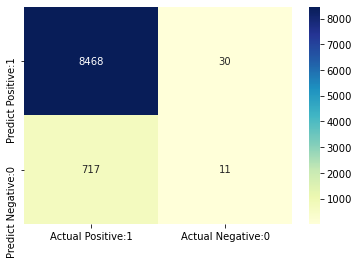

In [169]:
#visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [170]:

print(classification_report(y_val_s, y_pred_lgbm))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8498
         1.0       0.27      0.02      0.03       728

    accuracy                           0.92      9226
   macro avg       0.60      0.51      0.49      9226
weighted avg       0.87      0.92      0.88      9226



### Gridsearch

In [171]:
params_lgbm = {'boosting_type':['gbdt', 'dart', 'goss', 'rf'], 
               'num_leaves':[16,32,64],
               'reg_alpha':np.logspace(-3, 3, 7,),
               'reg_lambda':np.logspace(-5,5,10)}

In [172]:
lgbm = LGBMClassifier(random_state=1)

In [173]:
lgbm_cv = GridSearchCV(lgbm, params_lgbm, scoring="roc_auc", cv=skf)

In [174]:
lgbm_cv.fit(X_train_s, y_train_s)

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 55, in _safe_call
   

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(random_state=1),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                         'num_leaves': [16, 32, 64],
                         'reg_alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'reg_lambda': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])},
             scoring='roc_auc')

In [175]:
pd.DataFrame(lgbm_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_num_leaves,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.422869,0.024392,0.005401,0.000490,gbdt,16,0.001,1e-05,"{'boosting_type': 'gbdt', 'num_leaves': 16, 'r...",0.724037,0.729467,0.740998,0.739613,0.742911,0.735405,0.007346,201
1,0.404957,0.008950,0.005601,0.000800,gbdt,16,0.001,0.000129155,"{'boosting_type': 'gbdt', 'num_leaves': 16, 'r...",0.724039,0.729471,0.742437,0.739422,0.742911,0.735656,0.007563,198
2,0.428099,0.031704,0.005801,0.000749,gbdt,16,0.001,0.0016681,"{'boosting_type': 'gbdt', 'num_leaves': 16, 'r...",0.727704,0.735041,0.743836,0.736425,0.741853,0.736972,0.005672,177
3,0.416693,0.025317,0.005802,0.000748,gbdt,16,0.001,0.0215443,"{'boosting_type': 'gbdt', 'num_leaves': 16, 'r...",0.727092,0.732004,0.740022,0.736189,0.752753,0.737612,0.008709,168
4,0.402490,0.005005,0.005201,0.000400,gbdt,16,0.001,0.278256,"{'boosting_type': 'gbdt', 'num_leaves': 16, 'r...",0.731181,0.740263,0.741074,0.733183,0.743127,0.737766,0.004697,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.150865,0.005709,0.000000,0.000000,rf,64,1000,3.59381,"{'boosting_type': 'rf', 'num_leaves': 64, 'reg...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,703
836,0.152635,0.004801,0.000000,0.000000,rf,64,1000,46.4159,"{'boosting_type': 'rf', 'num_leaves': 64, 'reg...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,704
837,0.153483,0.006969,0.000000,0.000000,rf,64,1000,599.484,"{'boosting_type': 'rf', 'num_leaves': 64, 'reg...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,705
838,0.147433,0.002059,0.000000,0.000000,rf,64,1000,7742.64,"{'boosting_type': 'rf', 'num_leaves': 64, 'reg...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,810


In [176]:
lgbm_cv.best_params_

{'boosting_type': 'gbdt',
 'num_leaves': 16,
 'reg_alpha': 10.0,
 'reg_lambda': 46.41588833612782}

In [179]:
lgbm2 = LGBMClassifier(boosting_type='gbdt',
                       num_leaves=16,
                       reg_alpha=10.0,
                       reg_lambda=46.41588833612782,
                       random_state=1)

In [180]:
cross_val_score(lgbm2, X_train_s, y_train_s, cv=skf, scoring='roc_auc')

array([0.74738374, 0.7492908 , 0.75692456, 0.74981455, 0.75958534])

In [181]:
start_time = time.time()

lgbm2.fit(X_train_s, y_train_s)

temp_fit_lgbm2 = time.time()-start_time

In [182]:
start_time = time.time()

y_pred_cv_lgbm2 = lgbm2.predict(X_val_s)

temp_pred_lgbm_cv = time.time()-start_time

y_prob_lgbm2 = lgbm2.predict_proba(X_val_s)[:,1]

In [183]:
acc_cv_lgbm = accuracy_score(y_pred_cv_lgbm2, y_val_s)
print(acc_cv_lgbm)



auc_cv_lgbm = roc_auc_score(y_val_s, y_prob_lgbm2)
print(auc_cv_lgbm)

0.9206590071536961
0.7465032173051707


In [184]:
dico_lgbm_cv = {'modèle': 'lgbm_cv', 'fit': temp_fit_lgbm2, 'pred': temp_pred_lgbm_cv,
                'acc': acc_cv_lgbm, 'auc': auc_cv_lgbm}


comparatif_sample = comparatif_sample.append(dico_lgbm_cv, ignore_index=True)

## Sélection des trois "meilleurs" modèles

In [185]:
comparatif_sample 

,acc,auc,fit,modèle,pred
0,0.920442,0.735820,1.776184,reg_log,0.004001
1,0.921093,0.732816,0.159681,reg_log_cv,0.004000
2,0.921093,NaN,139.626045,svc,16.417820
3,0.921093,0.732816,0.159681,reg_log_cv,0.004000
4,0.920009,0.731478,0.516893,sgdc_cv,0.004000
5,0.921093,0.681336,6.356423,forest,0.188049
6,0.921093,0.717460,2.401438,forest_cv,0.071015
7,0.920009,0.748984,20.044426,gbc,0.019004
8,0.920876,0.749161,20.246126,gbc_cv,0.019999
9,0.108064,0.508461,0.072016,bayes,0.030007


In [186]:
comparatif_sample.sort_values('acc', ascending = False)

,acc,auc,fit,modèle,pred
1,0.921093,0.732816,0.159681,reg_log_cv,0.004000
2,0.921093,NaN,139.626045,svc,16.417820
3,0.921093,0.732816,0.159681,reg_log_cv,0.004000
5,0.921093,0.681336,6.356423,forest,0.188049
6,0.921093,0.717460,2.401438,forest_cv,0.071015
12,0.921093,0.500000,0.000999,dummy,0.000000
8,0.920876,0.749161,20.246126,gbc_cv,0.019999
11,0.920767,0.720233,15.126049,mlpc_cv,0.027007
14,0.920659,0.746503,0.466191,lgbm_cv,0.018003
0,0.920442,0.735820,1.776184,reg_log,0.004001


In [187]:
comparatif_sample.sort_values('auc', ascending = False)

,acc,auc,fit,modèle,pred
8,0.920876,0.749161,20.246126,gbc_cv,0.019999
7,0.920009,0.748984,20.044426,gbc,0.019004
14,0.920659,0.746503,0.466191,lgbm_cv,0.018003
13,0.919033,0.738185,0.528118,lgbm,0.018004
0,0.920442,0.735820,1.776184,reg_log,0.004001
1,0.921093,0.732816,0.159681,reg_log_cv,0.004000
3,0.921093,0.732816,0.159681,reg_log_cv,0.004000
4,0.920009,0.731478,0.516893,sgdc_cv,0.004000
11,0.920767,0.720233,15.126049,mlpc_cv,0.027007
6,0.921093,0.717460,2.401438,forest_cv,0.071015


On va conserver les trois modèles suivants : 
\begin{itemize}
\item Light GBM
\item Regression Logistique
\item Gradient Boosting Machine
\end{itemize}


# Courbe ROC


In [ ]:
plt.figure(figsize=(12,8))

fpr, tpr, _ = roc_curve(y_val_s, proba_gbc)
plt.plot(fpr, tpr,":", label='gbc')
#####

fpr, tpr, _ = roc_curve(y_val_s, proba_forest)
plt.plot(fpr, tpr,":", label='forest')
#####

fpr, tpr, _ = roc_curve(y_val_s, proba_mlpc)
plt.plot(fpr, tpr,":", label='mlpc')
#####

plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.legend()

In [242]:
y_probt_mplc_cv = mlpc_cv.predict_proba(X_val_s)

In [246]:
y_probt_mplc_cv

array([[0.97315336, 0.02684664],
       [0.90994559, 0.09005441],
       [0.95093599, 0.04906401],
       ...,
       [0.90078997, 0.09921003],
       [0.69310331, 0.30689669],
       [0.98274463, 0.01725537]])

In [252]:
y_probt_mplc_cv[:,1][0]

0.02684663537765184

In [260]:
def seuil(k,y_predprob):
    classification = []
    for i in range(len(y_predprob)):
        if y_predprob[:,1][i]>k:
            classification.append(1)
        else:
            classification.append(0)
    return classification

In [263]:
s1 = seuil(0.5,y_probt_mplc_cv) 

In [264]:
s1 == y_pred_mlpc_cv

array([ True,  True,  True, ...,  True,  True,  True])

In [258]:
cm = confusion_matrix(y_val_s, y_pred_mlpc_cv)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[8460   16]
 [ 737   13]]

True Positives(TP) =  8460

True Negatives(TN) =  13

False Positives(FP) =  16

False Negatives(FN) =  737


<AxesSubplot:>

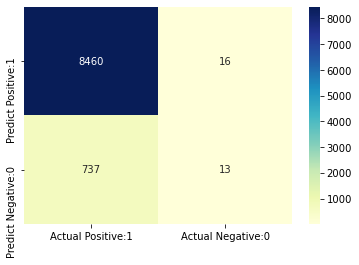

In [259]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [272]:
tp = []
tn = []
fp = []
fn = []

for i in np.arange(0.,1.,0.1):
    s = seuil(i, y_probt_mplc_cv)
    cm = confusion_matrix(y_val_s, s)
    tp.append(cm[0,0])
    tn.append(cm[1,1])
    fp.append(cm[0,1])
    fn.append(cm[1,0])

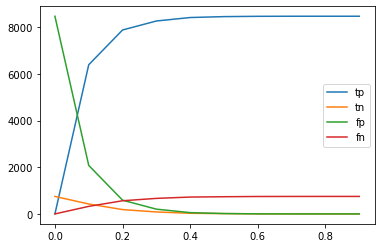

In [274]:
x = np.arange(0.,1.,0.1)

fig = plt.figure()
plt.plot(x, tp, label='tp')

plt.plot(x, tn, label='tn')

plt.plot(x, fp, label='fp')

plt.plot(x, fn, label='fn')

plt.legend()

In [194]:
shap_values = shap.TreeExplainer(forest).shap_values(X_train_s)

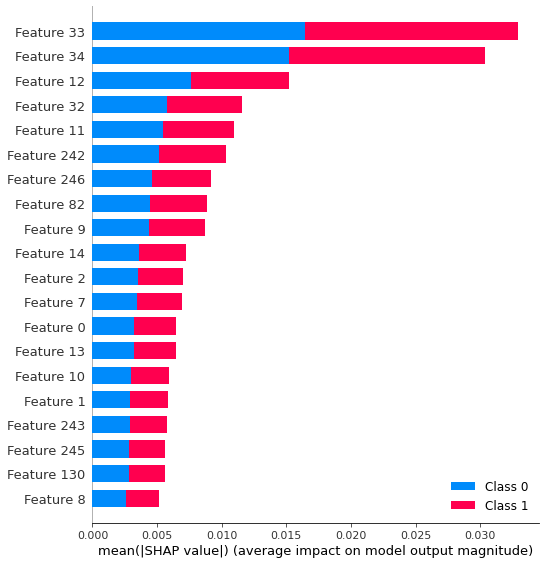

In [195]:
shap.summary_plot(shap_values, X_train_s, plot_type="bar")

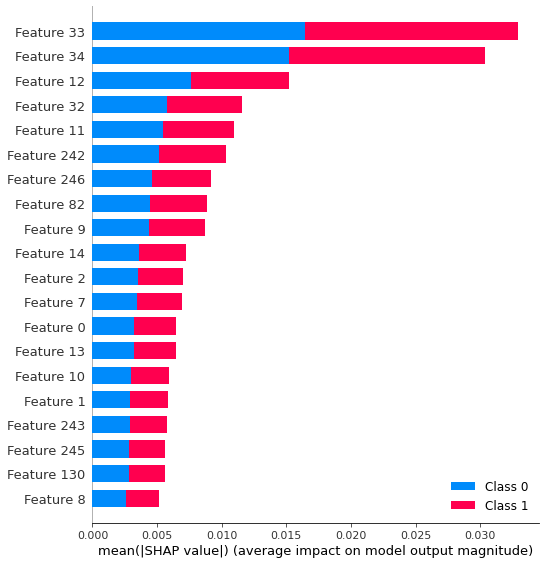

In [197]:
f = plt.figure()
shap.summary_plot(shap_values, X_val_s)

In [199]:
train_test.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC',
       'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE'],
      dtype='object', length=248)

In [200]:
shap.dependence_plot('WALLSMATERIAL_MODE_Panel', shap_values, X_train_s)

TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.

# Entraînement sur le dataset complet des meilleurs modèles

In [276]:
X_train.shape

(215254, 247)

## Regression logistique

### Direct

In [17]:
log_reg_c = LogisticRegression(max_iter=1000, random_state=1, class_weight='balanced')

In [18]:
start_time = time.time()

log_reg_c.fit(X_scaled, y_train)

temp_fit_log_c = time.time()-start_time

In [19]:
start_time = time.time()

y_pred_log_c = log_reg_c.predict(X_val)

temp_pred_log_c = time.time()-start_time

In [20]:
y_prob_reg_c = log_reg_c.predict_proba(X_val)[:,1]

In [21]:
acc_log_c = accuracy_score(y_pred_log_c, y_val)

auc_log_c = roc_auc_score(y_val, y_prob_reg_c)

print(acc_log_c, auc_log_c)

0.6879451074761797 0.7505108563646772


In [22]:
f1_score(y_pred_log_c, y_val)

0.26146741918932787

### Test sur solver newton-cg

In [23]:
log_reg_newt = LogisticRegression(max_iter=1000, solver='newton-cg', random_state=1, class_weight='balanced')

In [24]:
start_time = time.time()

log_reg_newt.fit(X_scaled, y_train)

temp_fit_log_newt = time.time()-start_time

In [25]:
start_time = time.time()

y_pred_log_newt = log_reg_newt.predict(X_val)

temp_pred_log_newt = time.time()-start_time

In [26]:
y_prob_reg_newt = log_reg_newt.predict_proba(X_val)[:,1]

In [27]:
acc_log__newt = accuracy_score(y_pred_log_newt, y_val)

auc_log__newt = roc_auc_score(y_val, y_prob_reg_newt)

print(acc_log_c, auc_log_c)

0.6879451074761797 0.7505108563646772


### Gridsearch

In [28]:
params_reg_c = {'solver':['sag', 'lbfgs'], 'penalty':['l2'], 'C':np.logspace(-3,3,7)}

In [29]:
log_reg_c = LogisticRegression(max_iter=1000, random_state=1, class_weight='balanced')

In [30]:
log_reg_c_cv = GridSearchCV(log_reg_c, params_reg_c, cv=skf, scoring='roc_auc')

In [31]:
log_reg_c_cv.fit(X_scaled, y_train)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2'], 'solver': ['sag', 'lbfgs']},
             scoring='roc_auc')

In [32]:
pd.DataFrame(log_reg_c_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,95.411408,17.610077,0.027606,4.900376e-04,0.001,l2,sag,"{'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}",0.747750,0.747139,0.745126,0.745827,0.743584,0.745885,0.001478,14
1,3.233724,0.154315,0.026806,4.003527e-04,0.001,l2,lbfgs,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.747758,0.747154,0.745138,0.745832,0.743593,0.745895,0.001479,13
2,248.438354,43.175073,0.027006,1.784161e-07,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.747987,0.747807,0.745870,0.746376,0.744350,0.746478,0.001338,2
3,7.177996,0.460331,0.027206,4.001381e-04,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.747991,0.747840,0.745851,0.746346,0.744343,0.746474,0.001350,7
4,322.081937,2.782765,0.027575,8.257460e-04,0.1,l2,sag,"{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}",0.747933,0.747949,0.745921,0.746224,0.744386,0.746483,0.001344,1
5,13.803409,1.096462,0.027606,4.898819e-04,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.747928,0.748005,0.745764,0.746011,0.744279,0.746398,0.001412,8
6,334.128349,6.663415,0.028604,7.996986e-04,1,l2,sag,"{'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}",0.747923,0.747963,0.745922,0.746191,0.744384,0.746477,0.001347,3
7,21.732819,3.536999,0.027406,4.900767e-04,1,l2,lbfgs,"{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.747905,0.748021,0.745694,0.745916,0.744192,0.746345,0.001448,9
8,334.542090,1.688786,0.028405,1.016965e-03,10,l2,sag,"{'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}",0.747922,0.747964,0.745922,0.746187,0.744384,0.746476,0.001347,4
9,21.823260,3.280056,0.028005,6.302267e-04,10,l2,lbfgs,"{'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.747905,0.748016,0.745686,0.745904,0.744168,0.746336,0.001456,10


In [33]:
log_reg_c_cv.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

In [22]:
log_reg_c_2 = LogisticRegression(max_iter=1000, class_weight='balanced', solver='sag', C=0.1, penalty='l2', random_state=1)

In [ ]:
cross_val_score(log_reg_c_2, X_scaled, y_train, cv=skf, scoring='roc_auc')

The max_iter was reached which means the coef_ did not converge


In [23]:
start_time = time.time()

log_reg_c_2.fit(X_scaled, y_train)

temp_fit_log_c_2 = time.time()-start_time

The max_iter was reached which means the coef_ did not converge


In [24]:
start_time = time.time()

y_pred_reg_c_2 = log_reg_c_2.predict(X_val)

temp_pred_log_c_2 = time.time()-start_time

y_prob_reg_c_2 = log_reg_c_2.predict_proba(X_val)[:,1]

In [25]:
acc_cv_reg_c = accuracy_score(y_pred_reg_c_2, y_val)
print(acc_cv_reg_c)


auc_cv_reg_c = roc_auc_score(y_val, y_prob_reg_c_2)
print(auc_cv_reg_c)

0.6881619025939536
0.7505711877966581


In [26]:
print(classification_report(y_val, y_pred_reg_c_2))

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     84805
         1.0       0.16      0.68      0.26      7448

    accuracy                           0.69     92253
   macro avg       0.56      0.69      0.53     92253
weighted avg       0.90      0.69      0.76     92253



In [27]:
f1_score(y_val, y_pred_reg_c_2)

0.2616774458474489

## LightGBM

### Direct

In [209]:
lgbm_c = LGBMClassifier(class_weight='balanced', random_state=1)

In [210]:
start_time = time.time()

lgbm_c.fit(X_scaled, y_train)

temp_fit_lgbm_c = time.time()-start_time

In [211]:
start_time = time.time()

y_pred_lgbm_c = lgbm_c.predict(X_val)

temp_pred_lgbm_c = time.time()-start_time

y_prob_lgbm_c = lgbm_c.predict_proba(X_val)[:,1]

In [212]:
acc_lgbm_c = accuracy_score(y_pred_lgbm_c, y_val)
print(acc_lgbm_c)

auc_lgbm_c = roc_auc_score(y_val, y_prob_lgbm_c)
print(auc_lgbm_c)

0.7115107367782078
0.7647081562168494


In [213]:
print(classification_report(y_val, y_pred_lgbm_c))

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     84805
         1.0       0.17      0.68      0.27      7448

    accuracy                           0.71     92253
   macro avg       0.57      0.70      0.55     92253
weighted avg       0.90      0.71      0.78     92253



In [214]:
f1_score(y_val, y_pred_lgbm_c)

0.2744670410555586

In [215]:
lgbm_c = LGBMClassifier(class_weight='balanced', random_state=1)

In [216]:
cross_val_score(lgbm_c, X_scaled, y_train, cv=skf, scoring='roc_auc')

array([0.76375523, 0.76220468, 0.75913852, 0.76203067, 0.75981661])

### RandomSearch

In [364]:

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


In [365]:
param_test

{'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen at 0x2ad697d5ac0>,
 'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen at 0x2ad517ea3a0>,
 'min_child_weight': [1e-05,
  0.001,
  0.01,
  0.1,
  1,
  10.0,
  100.0,
  1000.0,
  10000.0],
 'subsample': <scipy.stats._distn_infrastructure.rv_frozen at 0x2ad476b0f40>,
 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen at 0x2ad697d5700>,
 'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10, 50, 100],
 'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50, 100]}

In [368]:
clf = LGBMClassifier(class_weight='balanced', random_state=1)

In [369]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=100,
    scoring='roc_auc',
    cv=skf,
    random_state=1)

In [370]:
gs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=1),
                   n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AD697D5700>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002...,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AD697D5AC0>,
                                        'reg_alpha': [0,

In [372]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.396268,0.384799,0.036408,0.004364,0.650213,496,10000,15,7,100,0.388871,"{'colsample_bytree': 0.6502132028215444, 'min_...",0.735775,0.734277,0.727952,0.731591,0.730376,0.731994,0.002780,93
1,2.747919,0.056566,0.056413,0.000800,0.637948,171,100,31,1,10,0.535356,"{'colsample_bytree': 0.6379484363776157, 'min_...",0.765889,0.763873,0.760096,0.764350,0.762008,0.763243,0.002002,25
2,2.503543,0.101682,0.046410,0.000800,0.811132,495,0.01,10,50,100,0.646952,"{'colsample_bytree': 0.8111317002380557, 'min_...",0.759885,0.759659,0.756763,0.759053,0.759909,0.759054,0.001186,85
3,3.217628,0.119456,0.057813,0.011199,0.484232,452,100,19,50,100,0.274241,"{'colsample_bytree': 0.4842321631571403, 'min_...",0.762457,0.760894,0.759482,0.761535,0.760564,0.760986,0.000991,68
4,2.483759,0.082644,0.054812,0.014109,0.710892,484,0.001,14,100,20,0.41844,"{'colsample_bytree': 0.7108915293651334, 'min_...",0.761183,0.760172,0.757001,0.760088,0.758770,0.759443,0.001442,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.179090,0.045908,0.043210,0.006941,0.867183,166,1,6,0,50,0.562115,"{'colsample_bytree': 0.867183042402637, 'min_c...",0.757623,0.757623,0.753004,0.755364,0.754157,0.755554,0.001847,89
96,2.784026,0.041620,0.044010,0.001265,0.493596,287,10,11,0.1,1,0.252297,"{'colsample_bytree': 0.4935955001830566, 'min_...",0.762026,0.760632,0.757208,0.759294,0.759552,0.759743,0.001592,78
97,2.685604,0.067658,0.061014,0.001095,0.67104,428,1,45,0,100,0.964168,"{'colsample_bytree': 0.6710398892148852, 'min_...",0.766208,0.764465,0.763212,0.765000,0.762856,0.764348,0.001218,2
98,2.764622,0.039303,0.058413,0.000490,0.649475,370,10,42,7,50,0.984329,"{'colsample_bytree': 0.6494752724504838, 'min_...",0.764398,0.764520,0.761259,0.763692,0.762569,0.763288,0.001229,24


In [373]:
gs.best_params_

{'colsample_bytree': 0.5808162972459361,
 'min_child_samples': 489,
 'min_child_weight': 0.001,
 'num_leaves': 48,
 'reg_alpha': 5,
 'reg_lambda': 50,
 'subsample': 0.6216464818060874}

In [376]:
clf_2 = LGBMClassifier(colsample_bytree=0.5808162972459361,
                       min_child_samples=489,
                       min_child_weight=0.001,
                       num_leaves=48,
                       reg_alpha=5,
                       reg_lambda=50,
                       subsample=0.6216464818060874,
                       class_weight='balanced', random_state=1)

In [375]:
cross_val_score(clf_2, X_train, y_train, cv=skf, scoring='roc_auc')

array([0.76676601, 0.76456454, 0.7621087 , 0.76602951, 0.7623641 ])

In [377]:
start_time = time.time()

clf_2.fit(X_train, y_train)

temp_fit_gbc = time.time()-start_time

In [378]:
start_time = time.time()

y_pred_clf_2 = clf_2.predict(X_val)

temp_pred_clf_2 = time.time()-start_time

y_prob_clf_2 = clf_2.predict_proba(X_val)[:,1]

In [381]:
acc_lgb_clf = accuracy_score(y_val, y_pred_clf_2)

print(acc_lgb_clf)

auc_lgb_clf = roc_auc_score(y_val, y_prob_clf_2)

print(auc_lgb_clf)

0.7191636044356281
0.7684998490566372


In [382]:
print(classification_report(y_val, y_pred_clf_2))

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.83     84805
         1.0       0.18      0.68      0.28      7448

    accuracy                           0.72     92253
   macro avg       0.57      0.70      0.55     92253
weighted avg       0.90      0.72      0.78     92253



In [383]:
f1_score(y_val, y_pred_clf_2)

0.2808127914723518

### Gridsearch

In [393]:
clf_3 = LGBMClassifier(class_weight='balanced', random_state=1)

In [394]:
param3_test = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf']}

In [395]:
clf3_cv = GridSearchCV(clf_3, param3_test, cv=skf, scoring='roc_auc')

In [396]:
start_time = time.time()

clf3_cv.fit(X_train, y_train)

temp_fit = time.time()-start_time

print(temp_fit)

C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2058, in __init__
    _safe_call(_LIB.LGBM_Booster

74.63282442092896


In [399]:
pd.DataFrame(clf3_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.792562,0.096364,0.049161,0.003129,gbdt,{'boosting_type': 'gbdt'},0.762781,0.761459,0.759619,0.761636,0.759485,0.760996,0.001264,2
1,3.733992,0.286191,0.051486,0.003352,dart,{'boosting_type': 'dart'},0.757885,0.755548,0.751335,0.754516,0.755668,0.754990,0.002132,3
2,5.268544,0.196350,0.050185,0.001770,goss,{'boosting_type': 'goss'},0.761846,0.761525,0.761213,0.762193,0.760857,0.761527,0.000468,1
3,1.537346,0.038187,0.000000,0.000000,rf,{'boosting_type': 'rf'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [400]:
clf_4 = LGBMClassifier(class_weight='balanced', random_state=1)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(clf_4, n_jobs=-1, param_grid=param_dist, cv = skf, scoring="roc_auc")
grid_search.fit(X_train,y_train)
grid_search.best_estimator_

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=50,
               n_estimators=200, num_leaves=300, random_state=1)

In [32]:
clf_5 = LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=50,
               n_estimators=200, num_leaves=300, random_state=1)

In [36]:
cross_val_score(clf_5, X_train, y_train, cv=skf, scoring='roc_auc')

C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JordyP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\JordyP\anaconda3\lib\site-packages\lightgbm\basic.py", line 2053, in __init__
    train_set.construct()
  File

array([nan, nan, nan, nan, nan])

In [39]:
clf_5.fit(X_scaled, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=50,
               n_estimators=200, num_leaves=300, random_state=1)

In [40]:
y_pred = clf_5.predict(X_val)

In [43]:
y_prob = clf_5.predict_proba(X_val)[:,1]

In [44]:
acc_test5 = accuracy_score(y_pred, y_val)
print(acc_test5)

auc_test5 = roc_auc_score(y_val, y_prob)
print(auc_test5)

0.8131768072583005
0.7554586544059408


### Autre Randomsearch

In [48]:
param_test = {'n_estimators': sp_randint(50, 1500),
              'num_leaves': sp_randint(10, 500),
              # 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              # 'reg_lambda': [40, 50, 60, 70, 100],
              "learning_rate": sp_uniform(0, 1),
              "max_depth": sp_randint(5, 100)
              }

In [49]:
clf = LGBMClassifier(is_unbalance=True, random_state=1, force_row_wise=True)

In [50]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=20,
    scoring='roc_auc',
    cv=skf,
    random_state=1)

In [51]:
gs.fit(X_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True, random_state=1),
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A2E236A0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A2E23AF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A2E23130>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A2E23310>},
                   random_state=1, scoring='roc_auc')

In [52]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,51.413242,6.631541,0.793947,0.048274,0.417022,17,1146,265,"{'learning_rate': 0.417022004702574, 'max_dept...",0.710477,0.710598,0.709420,0.713421,0.709902,0.710764,0.001394,7
1,31.624977,1.204797,0.662476,0.028476,0.128124,10,897,458,"{'learning_rate': 0.12812444792935673, 'max_de...",0.704689,0.700584,0.703391,0.695383,0.694983,0.699806,0.004003,10
2,53.421198,3.773776,0.653484,0.044514,0.0923386,81,799,400,"{'learning_rate': 0.0923385947687978, 'max_dep...",0.731471,0.723531,0.724839,0.726812,0.728604,0.727052,0.002803,3
3,16.753338,1.581155,0.125435,0.020026,0.935539,25,1328,367,"{'learning_rate': 0.9355390708060318, 'max_dep...",0.569396,0.575728,0.574840,0.554840,0.540829,0.563127,0.013425,19
4,10.441517,0.219639,0.173041,0.030150,0.68522,16,302,166,"{'learning_rate': 0.6852195003967595, 'max_dep...",0.610725,0.581415,0.576813,0.591909,0.567086,0.585590,0.014890,14
5,27.621925,0.313434,0.368503,0.003007,0.0273876,55,630,225,"{'learning_rate': 0.027387593197926163, 'max_d...",0.751787,0.748351,0.746045,0.751765,0.749893,0.749568,0.002179,1
6,36.827978,0.679846,0.553345,0.058940,0.457205,99,1160,151,"{'learning_rate': 0.45720480798698826, 'max_de...",0.710025,0.708442,0.703309,0.712584,0.701042,0.707080,0.004278,8
7,11.584530,0.218423,0.245458,0.029511,0.715971,12,369,327,"{'learning_rate': 0.7159705159683643, 'max_dep...",0.571771,0.587685,0.582299,0.602601,0.555059,0.579883,0.015905,15
8,5.929872,0.298027,0.148734,0.015605,0.692323,6,366,219,"{'learning_rate': 0.6923226156693141, 'max_dep...",0.584295,0.523515,0.594195,0.567678,0.594244,0.572785,0.026476,17
9,44.622627,1.017995,0.548327,0.018879,0.0850442,18,677,441,"{'learning_rate': 0.08504421136977791, 'max_de...",0.729645,0.725975,0.722985,0.727996,0.724526,0.726225,0.002378,4


In [53]:
gs.best_params_

{'learning_rate': 0.027387593197926163,
 'max_depth': 55,
 'n_estimators': 630,
 'num_leaves': 225}

In [199]:
param_test = {'n_estimators': sp_randint(500, 2000),
              'num_leaves': sp_randint(10, 200),
              "learning_rate": sp_uniform(0, 1),
              "max_depth": sp_randint(10, 200)
              }

In [200]:
clf = LGBMClassifier(is_unbalance=True, random_state=1, force_row_wise=True)

In [201]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=100,
    scoring='roc_auc',
    cv=skf,
    random_state=1)

In [202]:
gs.fit(X_scaled, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True, random_state=1),
                   n_iter=100,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A00A22B0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A0194E50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A01ADB20>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230A0129C40>},
                   random_state=1, scoring='roc_auc')

In [203]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.067632,0.325592,0.737766,0.005390,0.417022,150,1596,147,"{'learning_rate': 0.417022004702574, 'max_dept...",0.708277,0.711165,0.713215,0.702402,0.711178,0.709247,0.003767,28
1,38.680281,0.323846,0.559526,0.009523,0.302333,89,1460,154,"{'learning_rate': 0.30233257263183977, 'max_de...",0.708023,0.716766,0.710950,0.705184,0.710634,0.710311,0.003839,25
2,32.239201,0.124212,0.478108,0.009697,0.396581,81,1249,144,"{'learning_rate': 0.3965807272960261, 'max_dep...",0.704489,0.701851,0.709315,0.700145,0.706097,0.704379,0.003214,30
3,19.892464,0.753900,0.199845,0.033951,0.935539,30,1778,111,"{'learning_rate': 0.9355390708060318, 'max_dep...",0.568949,0.568935,0.577532,0.586070,0.563511,0.573000,0.007929,66
4,16.926399,0.509944,0.224250,0.015410,0.68522,149,752,166,"{'learning_rate': 0.6852195003967595, 'max_dep...",0.590890,0.558007,0.577328,0.509721,0.588333,0.564856,0.029904,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16.769564,0.149846,0.401690,0.004129,0.0682093,149,1969,24,"{'learning_rate': 0.06820934841670412, 'max_de...",0.739392,0.740788,0.740290,0.734538,0.739192,0.738840,0.002229,10
96,22.056950,0.183816,0.311470,0.004884,0.0444179,146,668,186,"{'learning_rate': 0.044417941433287034, 'max_d...",0.736587,0.741780,0.742863,0.735427,0.738892,0.739110,0.002870,9
97,16.604927,0.558283,0.179440,0.023725,0.874962,150,1157,171,"{'learning_rate': 0.8749616449558981, 'max_dep...",0.565303,0.568769,0.586308,0.544784,0.562281,0.565489,0.013291,79
98,27.339336,0.158149,0.400290,0.004793,0.345172,143,1145,131,"{'learning_rate': 0.345172051155215, 'max_dept...",0.702273,0.705862,0.709768,0.701892,0.698414,0.703642,0.003866,31


In [204]:
gs.best_params_

{'learning_rate': 0.009999724800484167,
 'max_depth': 106,
 'n_estimators': 600,
 'num_leaves': 97}

In [205]:
clf2 = LGBMClassifier(learning_rate=0.009999724800484167,
 max_depth=106,
 n_estimators=600,
 num_leaves=97, is_unbalance=True, random_state=1, force_row_wise=True)

In [206]:
clf2.fit(X_scaled, y_train)

LGBMClassifier(force_row_wise=True, is_unbalance=True,
               learning_rate=0.009999724800484167, max_depth=106,
               n_estimators=600, num_leaves=97, random_state=1)

In [207]:
y_probi = clf2.predict_proba(X_val, pred_contrib=True)[:,1]

In [208]:
print("AUC", roc_auc_score(y_val, y_probi))

AUC 0.7681506353965131


In [210]:
shap = clf2.predict_proba(X_val, pred_contrib=True)

In [211]:
display(shap)

array([[ 4.25252870e-04,  1.03156641e-03, -6.99332723e-02, ...,
        -3.49325602e-02,  2.62157088e-01, -6.04904655e-01],
       [ 5.24038875e-03,  3.09002583e-03, -1.24857394e-01, ...,
        -3.32534515e-02, -8.70940231e-01, -6.04904655e-01],
       [ 9.22678904e-03,  3.97369493e-04,  1.81291476e-01, ...,
        -1.82272415e-02,  1.35959784e-01, -6.04904655e-01],
       ...,
       [-1.63775170e-03,  1.80720278e-03, -7.80762365e-02, ...,
        -3.38027475e-02,  2.15283391e-02, -6.04904655e-01],
       [-8.24357351e-03,  2.63188125e-03,  1.98423505e-01, ...,
        -1.37145227e-02,  1.83888849e-01, -6.04904655e-01],
       [-3.18745937e-02,  3.19088482e-03, -1.63242216e-01, ...,
         2.30938216e-02, -7.91756817e-01, -6.04904655e-01]])

In [212]:
shap.shape

(92253, 248)

In [276]:
clf2 = LGBMClassifier(max_depth=50,
                      num_leaves=381,
                      reg_alpha=0.01,
                      reg_lambda=0.08,
                      feature_fraction=0.899,
                      bagging_fraction=0.899, class_weight='balanced', random_state=1, force_row_wise=True)

In [277]:
clf2.fit(X_scaled, y_train)

[LightGBM] [Warning] feature_fraction is set=0.899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.899
[LightGBM] [Warning] bagging_fraction is set=0.899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899


LGBMClassifier(bagging_fraction=0.899, class_weight='balanced',
               feature_fraction=0.899, force_row_wise=True, max_depth=50,
               num_leaves=381, random_state=1, reg_alpha=0.01, reg_lambda=0.08)

In [278]:
y_prob2= clf2.predict_proba(X_val)[:,1]

In [279]:
print("AUC", roc_auc_score(y_val, y_prob2))

AUC 0.7527121596515315


In [295]:
lgbmodel_2_wt = LGBMClassifier(boosting_type='gbdt',
                        num_leaves= 105, 
                        max_depth= 11,
                        learning_rate=0.03,
                        n_estimators= 10000,
                        objective='binary',
                        class_weight= {0: 0.6, 1: 1},
                        min_split_gain=0.01,
                        min_child_weight=2,
                        min_child_samples=20,
                        subsample=0.9,
                        colsample_bytree=0.8,
                        reg_alpha=0.1,
                        reg_lambda=0.1,
                        n_jobs= 8,
                        verbose= -1)

In [296]:
from lightgbm import record_evaluation
history = {}
eval_history = record_evaluation(history)
lgbmodel_2_wt.fit(
    X_scaled, y_train,
    eval_set= [(X_scaled, y_train), (X_val, y_val)],
    eval_metric='auc', verbose=500, early_stopping_rounds=100,
    callbacks= [eval_history])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	training's auc: 0.873872	training's binary_logloss: 0.277862	valid_1's auc: 0.768614	valid_1's binary_logloss: 0.251512


LGBMClassifier(class_weight={0: 0.6, 1: 1}, colsample_bytree=0.8,
               learning_rate=0.03, max_depth=11, min_child_weight=2,
               min_split_gain=0.01, n_estimators=10000, n_jobs=8,
               num_leaves=105, objective='binary', reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.9, verbose=-1)

In [297]:
y_pred = lgbmodel_2_wt.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, y_pred))

0.7686136724478998


In [299]:
import lightgbm as lgb

In [300]:
train_data=lgb.Dataset(X_scaled, label=y_train)

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

In [301]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

In [302]:
# Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [304]:
# View the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=skf, n_jobs=-1)

# Run the grid
grid.fit(X_scaled, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 8, 'num_leaves': 20, 'objective': 'binary', 'random_state': 501, 'subsample': 0.7}
0.919272115769237


In [305]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 20, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}


In [312]:
clf2 = LGBMClassifier(boosting_type='gbdt', max_depth=-1, objective='binary', n_jobs=5, num_leaves=20, 
                      learning_rate=0.07, max_bin=512, subsample_for_bin=200, subsample=0.7, 
                      subsample_freq=1, colsample_bytree=0.64, reg_alpha=1.2, reg_lambda=1.2,
                      min_split_gain=0.5, min_child_weight=1, min_child_samples=5, scale_pos_weight=1, 
                      num_class=1,
                      is_unbalance=True, random_state=1, force_row_wise=True)

In [313]:
clf2.fit(X_scaled, y_train)

LGBMClassifier(colsample_bytree=0.64, force_row_wise=True, is_unbalance=True,
               learning_rate=0.07, max_bin=512, min_child_samples=5,
               min_child_weight=1, min_split_gain=0.5, n_jobs=5, num_class=1,
               num_leaves=20, objective='binary', random_state=1, reg_alpha=1.2,
               reg_lambda=1.2, scale_pos_weight=1, subsample=0.7,
               subsample_for_bin=200, subsample_freq=1)

In [314]:
y_prob = clf2.predict_proba(X_val)[:,1]

In [315]:
print("AUC", roc_auc_score(y_val, y_prob))

AUC 0.7630937572649608


#### de côté 
clf2 = LGBMClassifier(learning_rate=0.008002710652099565,
 max_depth=63,
 n_estimators=956,
 num_leaves=87, is_unbalance=True, random_state=1, force_row_wise=True)

In [132]:
gs.best_params_

{'colsample_bytree': 0.4510265268218668,
 'learning_rate': 0.05,
 'max_depth': 75,
 'min_child_samples': 521,
 'min_child_weight': 1e-05,
 'num_leaves': 582,
 'reg_alpha': 50,
 'reg_lambda': 70,
 'subsample': 0.9373232779377075}

In [65]:
gs.best_params_

{'colsample_bytree': 0.5793580673258296,
 'learning_rate': 0.05,
 'max_depth': 25,
 'min_child_samples': 474,
 'min_child_weight': 0.01,
 'num_leaves': 342,
 'reg_alpha': 0,
 'reg_lambda': 40,
 'subsample': 0.8267587924841403}

In [148]:
clf2 = LGBMClassifier(colsample_bytree=0.4510265268218668,
                      learning_rate=0.05,
                      max_depth=75,
                      min_child_samples=521,
                      min_child_weight=1e-05,
                      num_leaves=582,
                      reg_alpha=50,
                      reg_lambda=70,
                      subsample=0.9373232779377075,
                      is_unbalance=True, random_state=1, force_row_wise=True)

In [149]:
clf2.fit(X_scaled, y_train)

LGBMClassifier(colsample_bytree=0.4510265268218668, force_row_wise=True,
               is_unbalance=True, learning_rate=0.05, max_depth=75,
               min_child_samples=521, min_child_weight=1e-05, num_leaves=582,
               random_state=1, reg_alpha=50, reg_lambda=70,
               subsample=0.9373232779377075)

In [150]:
y_pred2 = clf2.predict(X_val)

In [151]:
y_prob2= clf2.predict_proba(X_val)[:,1]

In [152]:
print("Accu", accuracy_score(y_pred2, y_val))


print("AUC", roc_auc_score(y_val, y_prob2))


Accu 0.7151312152450326
AUC 0.7647023236665197


In [163]:
np.random.choice(['gbdt', 'dart', 'goss'])

'goss'

In [71]:
param_test = {'learning_rate': sp_uniform(0,1),
              'boosting_type': ['gbdt', 'dart', 'goss'],
              'num_leaves': sp_randint(20, 1000),
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'max_depth': sp_randint(5, 200),
              'reg_alpha': sp_uniform(0, 500),
              'reg_lambda': sp_uniform(0, 500)
              }

In [72]:
#Train using selected parameters
clf = LGBMClassifier(is_unbalance=True, random_state=1, force_row_wise=True)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=200,
    scoring='roc_auc',
    cv=skf,
    random_state=1)

In [73]:
gs.fit(X_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True, random_state=1),
                   n_iter=200,
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B60F269550>,
                                        'learning_rate': <scipy.stat...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B60F269CD0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B60F2615E0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B60F1FB0A0>,
  

In [74]:
gs.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.67779786045983,
 'learning_rate': 0.103299630107204,
 'max_depth': 80,
 'num_leaves': 176,
 'reg_alpha': 62.748042616924295,
 'reg_lambda': 65.60695882630341}

In [75]:
clf2 = LGBMClassifier(boosting_type='gbdt',
                      colsample_bytree=0.67779786045983,
                      learning_rate=0.103299630107204,
                      max_depth=80,
                      num_leaves=176,
                      reg_alpha=62.748042616924295,
                      reg_lambda=65.60695882630341,
                      is_unbalance=True, random_state=1, force_row_wise=True)

In [76]:
clf2.fit(X_scaled, y_train)

LGBMClassifier(colsample_bytree=0.67779786045983, force_row_wise=True,
               is_unbalance=True, learning_rate=0.103299630107204, max_depth=80,
               num_leaves=176, random_state=1, reg_alpha=62.748042616924295,
               reg_lambda=65.60695882630341)

In [77]:
y_prob2= clf2.predict_proba(X_val)[:,1]

In [78]:
print("AUC", roc_auc_score(y_val, y_prob2))

AUC 0.6967353874824098


In [251]:
clf = LGBMClassifier(
    #nthread=12,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=30,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1,
    n_jobs=8
)

In [252]:
clf.fit(X_scaled, y_train, eval_set=[(X_scaled, y_train), (X_val, y_val)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.77647	training's binary_logloss: 0.241511	valid_1's auc: 0.762115	valid_1's binary_logloss: 0.245678
[400]	training's auc: 0.79621	training's binary_logloss: 0.234657	valid_1's auc: 0.768146	valid_1's binary_logloss: 0.243406
[600]	training's auc: 0.810361	training's binary_logloss: 0.229895	valid_1's auc: 0.76992	valid_1's binary_logloss: 0.242807
[800]	training's auc: 0.822707	training's binary_logloss: 0.225667	valid_1's auc: 0.770852	valid_1's binary_logloss: 0.242533
[1000]	training's auc: 0.833907	training's binary_logloss: 0.221748	valid_1's auc: 0.770932	valid_1's binary_logloss: 0.242479
Early stopping, best iteration is:
[984]	training's auc: 0.833097	training's binary_logloss: 0.222037	valid_1's auc: 0.771	valid_1's binary_logloss: 0.24246


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=30,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, n_jobs=8, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [253]:
y_prob2= clf.predict_proba(X_val)[:,1]

In [254]:
print("AUC", roc_auc_score(y_val, y_prob2))

AUC 0.7709999074771332


### Dernier test

In [14]:
param_test = {'learning_rate': sp_uniform(0,1),
              'num_leaves': sp_randint(20, 100),
              'max_depth': sp_randint(8, 100),
              'n_estimators': sp_randint(500, 10000)
              }

In [20]:
#Train using selected parameters
clf = LGBMClassifier(is_unbalance=True, random_state=1, force_row_wise=True)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=1,
    scoring='roc_auc',
    cv=skf,
    random_state=1)

In [21]:
gs.fit(X_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True, random_state=1),
                   n_iter=1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B68091ED60>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6809332B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B680933430>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6809330A0>},
                   random_state=1, scoring='roc_auc')

In [22]:
gs.best_params_

{'learning_rate': 0.417022004702574,
 'max_depth': 20,
 'n_estimators': 5692,
 'num_leaves': 29}

In [23]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,48.32462,0.716071,1.38931,0.074096,0.417022,20,5692,29,"{'learning_rate': 0.417022004702574, 'max_dept...",0.694807,0.697388,0.698294,0.69064,0.692567,0.694739,0.00287,1


### Vrai dernier

In [24]:
param_test = {'num_leaves': [20, 50, 100],
              'max_depth': [8, 25, 50],
              'n_estimators': [1000, 5000, 10000]
              }

In [25]:
#Train using selected parameters
clf = LGBMClassifier(learning_rate=0.02, is_unbalance=True, random_state=1, force_row_wise=True)

In [26]:
clf_cv = GridSearchCV(clf, param_test, cv=skf, scoring='roc_auc')

In [27]:
clf_cv.fit(X_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(force_row_wise=True, is_unbalance=True,
                                      learning_rate=0.02, random_state=1),
             param_grid={'max_depth': [8, 25, 50],
                         'n_estimators': [1000, 5000, 10000],
                         'num_leaves': [20, 50, 100]},
             scoring='roc_auc')

In [28]:
pd.DataFrame(clf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.805452,0.181821,0.271893,0.007655,8,1000,20,"{'max_depth': 8, 'n_estimators': 1000, 'num_le...",0.762338,0.766603,0.763822,0.755783,0.762043,0.762118,0.003555,3
1,13.499525,0.186702,0.371899,0.006250,8,1000,50,"{'max_depth': 8, 'n_estimators': 1000, 'num_le...",0.759541,0.763117,0.760111,0.752348,0.757272,0.758478,0.003588,6
2,17.020950,0.327868,0.483974,0.023369,8,1000,100,"{'max_depth': 8, 'n_estimators': 1000, 'num_le...",0.753246,0.755740,0.753281,0.747649,0.751812,0.752346,0.002667,9
3,36.687030,0.886335,1.148787,0.109948,8,5000,20,"{'max_depth': 8, 'n_estimators': 5000, 'num_le...",0.749673,0.753056,0.750021,0.743941,0.750236,0.749385,0.002977,12
4,55.357459,1.126984,2.541708,0.078677,8,5000,50,"{'max_depth': 8, 'n_estimators': 5000, 'num_le...",0.730134,0.735514,0.735145,0.725964,0.731966,0.731745,0.003517,18
5,70.720686,0.945950,6.195735,0.048471,8,5000,100,"{'max_depth': 8, 'n_estimators': 5000, 'num_le...",0.716792,0.721893,0.719705,0.714867,0.719853,0.718622,0.002483,23
6,66.965868,0.844419,4.661101,0.099088,8,10000,20,"{'max_depth': 8, 'n_estimators': 10000, 'num_l...",0.733875,0.738003,0.736067,0.730315,0.736615,0.734975,0.002682,15
7,102.890290,3.787325,9.664777,0.275936,8,10000,50,"{'max_depth': 8, 'n_estimators': 10000, 'num_l...",0.710500,0.717050,0.720214,0.708503,0.714334,0.714120,0.004252,26
8,147.635050,4.801417,14.290506,0.220158,8,10000,100,"{'max_depth': 8, 'n_estimators': 10000, 'num_l...",0.700094,0.701130,0.703380,0.698178,0.702880,0.701132,0.001893,27
9,10.814418,0.196053,0.296666,0.022083,25,1000,20,"{'max_depth': 25, 'n_estimators': 1000, 'num_l...",0.762622,0.767237,0.763676,0.755917,0.762138,0.762318,0.003664,1


In [29]:
clf_cv.best_params_

{'max_depth': 25, 'n_estimators': 1000, 'num_leaves': 20}

In [36]:
param_test = {'num_leaves': sp_randint(10, 30),
              'max_depth': sp_randint(20, 30),
              'n_estimators': sp_randint(500, 1500)
              }

In [37]:
#Train using selected parameters
clf = LGBMClassifier(learning_rate=0.02, is_unbalance=True, random_state=1, force_row_wise=True)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=100,
    scoring='roc_auc',
    cv=skf,
    random_state=1)

In [38]:
gs.fit(X_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True,
                                            learning_rate=0.02,
                                            random_state=1),
                   n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B680948E20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B68E5FBEE0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B68E5FBA60>},
                   random_state=1, scoring='roc_auc')

In [33]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.975127,0.341871,0.234441,0.021314,25,735,22,"{'max_depth': 25, 'n_estimators': 735, 'num_le...",0.763217,0.766994,0.764019,0.756130,0.762103,0.762492,0.003571,1
1,12.424202,0.524191,0.326600,0.014517,28,1267,19,"{'max_depth': 28, 'n_estimators': 1267, 'num_l...",0.762185,0.766972,0.763509,0.755764,0.761957,0.762077,0.003630,7
2,10.596676,0.342282,0.291428,0.004160,25,1347,10,"{'max_depth': 25, 'n_estimators': 1347, 'num_l...",0.762067,0.767164,0.764629,0.754932,0.761737,0.762106,0.004088,6
3,8.156389,0.257890,0.202060,0.009252,20,629,22,"{'max_depth': 20, 'n_estimators': 629, 'num_le...",0.763270,0.767282,0.764111,0.755741,0.762057,0.762492,0.003793,2
4,12.570557,0.893475,0.314370,0.006675,27,1249,16,"{'max_depth': 27, 'n_estimators': 1249, 'num_l...",0.762085,0.767010,0.763800,0.755482,0.762007,0.762077,0.003763,8
5,8.475056,0.312486,0.199785,0.008997,29,678,15,"{'max_depth': 29, 'n_estimators': 678, 'num_le...",0.762497,0.766873,0.764010,0.755134,0.761824,0.762067,0.003877,9
6,11.917776,0.610268,0.304701,0.023703,22,968,21,"{'max_depth': 22, 'n_estimators': 968, 'num_le...",0.763063,0.767038,0.763875,0.755496,0.761934,0.762281,0.003793,3
7,11.224472,0.114381,0.279143,0.002080,22,1080,19,"{'max_depth': 22, 'n_estimators': 1080, 'num_l...",0.762440,0.767239,0.763550,0.756105,0.761904,0.762248,0.003592,4
8,8.649728,0.093660,0.244055,0.022032,21,1003,10,"{'max_depth': 21, 'n_estimators': 1003, 'num_l...",0.762042,0.766965,0.764198,0.754610,0.761122,0.761787,0.004114,10
9,7.894093,0.126382,0.193085,0.001458,26,641,19,"{'max_depth': 26, 'n_estimators': 641, 'num_le...",0.763050,0.766946,0.763805,0.755324,0.761845,0.762194,0.003827,5


In [39]:
gs.best_params_

{'max_depth': 20, 'n_estimators': 753, 'num_leaves': 23}

In [40]:
clf = LGBMClassifier(max_depth=20, n_estimators=753, num_leaves=23,
                     learning_rate=0.02, is_unbalance=True, random_state=1, force_row_wise=True)

In [41]:
clf.fit(X_scaled, y_train)

LGBMClassifier(force_row_wise=True, is_unbalance=True, learning_rate=0.02,
               max_depth=20, n_estimators=753, num_leaves=23, random_state=1)

In [42]:
y_pro = clf.predict_proba(X_val)

In [43]:
y = y_pro[:,1]

In [44]:
print("AUC", roc_auc_score(y_val, y))

AUC 0.7685433493695748


In [46]:
grille_fin = {'reg_alpha':sp_uniform(0, 1),
    'reg_lambda':sp_uniform(0, 1),
    'min_split_gain':sp_uniform(0, 1),
    'min_child_weight':sp_uniform(0, 100)}

In [47]:
clf = LGBMClassifier(max_depth=20, n_estimators=753, num_leaves=23,
                     learning_rate=0.02, is_unbalance=True, random_state=1, force_row_wise=True)

In [48]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=grille_fin, 
    n_iter=10,
    scoring='roc_auc',
    cv=skf,
    random_state=1,
    verbose = 3,
    return_train_score = True)

In [49]:
gs.fit(X_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time=  10.3s
[CV 2/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time=  10.3s
[CV 3/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time=  10.3s
[CV 4/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time=  10.1s
[CV 5/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time=  10.3s
[CV 1/5] END min_child_weight=14.675589081711305, min_split_gain=0.0923385947687978, reg_alpha=0.18

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True,
                                            learning_rate=0.02, max_depth=20,
                                            n_estimators=753, num_leaves=23,
                                            random_state=1),
                   param_distributions={'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6B3390130>,
                                        'min_split_gain': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6B339C910>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6B339C670>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6B339C6D0>},
                   random_state=1, return

In [50]:
gs.best_params_

{'min_child_weight': 95.7889530150502,
 'min_split_gain': 0.5331652849730171,
 'reg_alpha': 0.6918771139504734,
 'reg_lambda': 0.31551563100606295}

In [51]:
clf3 = LGBMClassifier(max_depth=20, n_estimators=753, num_leaves=23,
                     learning_rate=0.02,
                     min_child_weight= 95.7889530150502,
                     min_split_gain= 0.5331652849730171,
                     reg_alpha= 0.6918771139504734,
                     reg_lambda= 0.31551563100606295,
                     is_unbalance=True, random_state=1, force_row_wise=True)

In [52]:
clf3.fit(X_scaled, y_train)

LGBMClassifier(force_row_wise=True, is_unbalance=True, learning_rate=0.02,
               max_depth=20, min_child_weight=95.7889530150502,
               min_split_gain=0.5331652849730171, n_estimators=753,
               num_leaves=23, random_state=1, reg_alpha=0.6918771139504734,
               reg_lambda=0.31551563100606295)

In [53]:
y_pro3 = clf3.predict_proba(X_val)[:,1]

In [54]:
print("AUC", roc_auc_score(y_val, y_pro3))

AUC 0.7699187182498853


In [55]:
grille_fin2= {
    'colsample_bytree':sp_uniform(0,1),
    'subsample':sp_uniform(0,1)}

In [56]:
clf3 = LGBMClassifier(max_depth=20, n_estimators=753, num_leaves=23,
                     learning_rate=0.02,
                     min_child_weight= 95.7889530150502,
                     min_split_gain= 0.5331652849730171,
                     reg_alpha= 0.6918771139504734,
                     reg_lambda= 0.31551563100606295,
                     is_unbalance=True, random_state=1, force_row_wise=True)

In [57]:
gs = RandomizedSearchCV(
    estimator=clf3, param_distributions=grille_fin2, 
    n_iter=10,
    scoring='roc_auc',
    cv=skf,
    random_state=1,
    verbose = 4,
    return_train_score = True)

In [58]:
gs.fit(X_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  11.2s
[CV 2/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  11.3s
[CV 3/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  11.7s
[CV 4/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  11.5s
[CV 5/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  11.4s
[CV 1/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   4.9s
[CV 2/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   4.9s
[CV 3/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   5.1s
[CV 4/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   4.9s
[CV 5/5] END colsample_bytree=0.0

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True,
                                            learning_rate=0.02, max_depth=20,
                                            min_child_weight=95.7889530150502,
                                            min_split_gain=0.5331652849730171,
                                            n_estimators=753, num_leaves=23,
                                            random_state=1,
                                            reg_alpha=0.6918771139504734,
                                            reg_lambda=0.31551563100606295),
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6B337C2B0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B6B3390B80>

In [59]:
gs.best_params_

{'colsample_bytree': 0.39676747423066994, 'subsample': 0.538816734003357}

In [61]:
clf4 = LGBMClassifier(max_depth=20, n_estimators=753, num_leaves=23,
                      learning_rate=0.02,
                      min_child_weight=95.7889530150502,
                      min_split_gain=0.5331652849730171,
                      reg_alpha=0.6918771139504734,
                      reg_lambda=0.31551563100606295,
                      colsample_bytree=0.39676747423066994,
                      subsample=0.538816734003357,
                      is_unbalance=True, random_state=1, force_row_wise=True)

In [62]:
clf4.fit(X_scaled, y_train)

LGBMClassifier(colsample_bytree=0.39676747423066994, force_row_wise=True,
               is_unbalance=True, learning_rate=0.02, max_depth=20,
               min_child_weight=95.7889530150502,
               min_split_gain=0.5331652849730171, n_estimators=753,
               num_leaves=23, random_state=1, reg_alpha=0.6918771139504734,
               reg_lambda=0.31551563100606295, subsample=0.538816734003357)

In [63]:
y_pro4 = clf4.predict_proba(X_val)[:,1]

In [64]:
print("AUC", roc_auc_score(y_val, y_pro4))

AUC 0.7710855417916798


In [35]:
gs.best_params_

{'max_depth': 25, 'n_estimators': 735, 'num_leaves': 22}

## Test sur un train plus grand

In [18]:
param_test = {'learning_rate':[0.1, 0.001, 0.003],
              'num_leaves': [20, 50, 100],
              'max_depth': [8, 25, 50],
              'n_estimators': [500, 1000, 5000]
              }

In [19]:
#Train using selected parameters
clf = LGBMClassifier(is_unbalance=True, random_state=1, force_row_wise=True)

clf_cv = GridSearchCV(clf, param_test, cv=skf, scoring='roc_auc', verbose=3)

In [20]:
clf_cv.fit(X_scaled1, y_train1)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=20; total time=   7.8s
[CV 2/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=20; total time=   7.7s
[CV 3/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=20; total time=   7.6s
[CV 4/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=20; total time=   7.8s
[CV 5/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=20; total time=   7.6s
[CV 1/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=50; total time=   9.9s
[CV 2/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=50; total time=  10.2s
[CV 3/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=50; total time=  10.1s
[CV 4/5] END learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=50; total time=  10.0s
[CV 5/5] END learning_rate=0.1, max_depth=8, n_estimators=500, nu

[CV 4/5] END learning_rate=0.1, max_depth=25, n_estimators=5000, num_leaves=50; total time= 1.3min
[CV 5/5] END learning_rate=0.1, max_depth=25, n_estimators=5000, num_leaves=50; total time= 1.3min
[CV 1/5] END learning_rate=0.1, max_depth=25, n_estimators=5000, num_leaves=100; total time= 2.0min
[CV 2/5] END learning_rate=0.1, max_depth=25, n_estimators=5000, num_leaves=100; total time= 2.1min
[CV 3/5] END learning_rate=0.1, max_depth=25, n_estimators=5000, num_leaves=100; total time= 2.0min
[CV 4/5] END learning_rate=0.1, max_depth=25, n_estimators=5000, num_leaves=100; total time= 2.0min
[CV 5/5] END learning_rate=0.1, max_depth=25, n_estimators=5000, num_leaves=100; total time= 2.0min
[CV 1/5] END learning_rate=0.1, max_depth=50, n_estimators=500, num_leaves=20; total time=   7.9s
[CV 2/5] END learning_rate=0.1, max_depth=50, n_estimators=500, num_leaves=20; total time=   8.0s
[CV 3/5] END learning_rate=0.1, max_depth=50, n_estimators=500, num_leaves=20; total time=   7.6s
[CV 4/5]

[CV 2/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=20; total time= 1.6min
[CV 3/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=20; total time= 1.5min
[CV 4/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=20; total time= 1.5min
[CV 5/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=20; total time= 1.5min
[CV 1/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=50; total time= 2.1min
[CV 2/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=50; total time= 2.1min
[CV 3/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=50; total time= 2.0min
[CV 4/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=50; total time= 2.0min
[CV 5/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=50; total time= 2.0min
[CV 1/5] END learning_rate=0.001, max_depth=8, n_estimators=5000, num_leaves=100; total time= 2.6min

[CV 4/5] END learning_rate=0.001, max_depth=50, n_estimators=1000, num_leaves=50; total time=  54.7s
[CV 5/5] END learning_rate=0.001, max_depth=50, n_estimators=1000, num_leaves=50; total time=  55.4s
[CV 1/5] END learning_rate=0.001, max_depth=50, n_estimators=1000, num_leaves=100; total time= 1.1min
[CV 2/5] END learning_rate=0.001, max_depth=50, n_estimators=1000, num_leaves=100; total time=  50.0s
[CV 3/5] END learning_rate=0.001, max_depth=50, n_estimators=1000, num_leaves=100; total time=  45.5s
[CV 4/5] END learning_rate=0.001, max_depth=50, n_estimators=1000, num_leaves=100; total time=  45.5s
[CV 5/5] END learning_rate=0.001, max_depth=50, n_estimators=1000, num_leaves=100; total time=  45.1s
[CV 1/5] END learning_rate=0.001, max_depth=50, n_estimators=5000, num_leaves=20; total time= 1.6min
[CV 2/5] END learning_rate=0.001, max_depth=50, n_estimators=5000, num_leaves=20; total time= 1.6min
[CV 3/5] END learning_rate=0.001, max_depth=50, n_estimators=5000, num_leaves=20; tota

[CV 1/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=20; total time=  21.5s
[CV 2/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=20; total time=  21.7s
[CV 3/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=20; total time=  21.2s
[CV 4/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=20; total time=  21.4s
[CV 5/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=20; total time=  21.2s
[CV 1/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=50; total time=  31.4s
[CV 2/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=50; total time=  32.4s
[CV 3/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=50; total time=  30.9s
[CV 4/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=50; total time=  31.1s
[CV 5/5] END learning_rate=0.003, max_depth=25, n_estimators=1000, num_leaves=50; total tim

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(force_row_wise=True, is_unbalance=True,
                                      random_state=1),
             param_grid={'learning_rate': [0.1, 0.001, 0.003],
                         'max_depth': [8, 25, 50],
                         'n_estimators': [500, 1000, 5000],
                         'num_leaves': [20, 50, 100]},
             scoring='roc_auc', verbose=3)

In [21]:
pd.DataFrame(clf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.602836,0.103953,0.177040,0.010680,0.1,8,500,20,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.761338,0.756344,0.759983,0.757306,0.761418,0.759278,0.002089,16
1,9.847012,0.133873,0.244855,0.021972,0.1,8,500,50,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.752025,0.744869,0.747000,0.747942,0.750431,0.748453,0.002526,35
2,12.279758,0.129284,0.352279,0.010030,0.1,8,500,100,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.739068,0.734598,0.737181,0.737174,0.738259,0.737256,0.001508,61
3,12.486103,0.148467,0.326361,0.015816,0.1,8,1000,20,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.753820,0.747001,0.750738,0.749682,0.752599,0.750768,0.002368,31
4,16.721521,0.196703,0.433298,0.038163,0.1,8,1000,50,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.737374,0.730657,0.732611,0.732878,0.734006,0.733505,0.002215,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,30.610275,0.229618,0.530119,0.052452,0.003,50,1000,50,"{'learning_rate': 0.003, 'max_depth': 50, 'n_e...",0.759607,0.754994,0.755704,0.755360,0.756213,0.756376,0.001665,24
77,46.005600,2.698291,0.750976,0.058428,0.003,50,1000,100,"{'learning_rate': 0.003, 'max_depth': 50, 'n_e...",0.760129,0.755958,0.755722,0.756576,0.758198,0.757317,0.001651,23
78,113.806721,9.030266,2.552939,0.113927,0.003,50,5000,20,"{'learning_rate': 0.003, 'max_depth': 50, 'n_e...",0.767961,0.762023,0.763910,0.762052,0.764245,0.764038,0.002166,1
79,169.556219,5.668861,5.154125,0.263868,0.003,50,5000,50,"{'learning_rate': 0.003, 'max_depth': 50, 'n_e...",0.767140,0.761895,0.763352,0.762071,0.764219,0.763735,0.001904,5


In [22]:
clf_cv.best_params_

{'learning_rate': 0.003,
 'max_depth': 25,
 'n_estimators': 5000,
 'num_leaves': 20}

In [12]:
param_test = {'learning_rate': sp_uniform(0.0001, 0.001),
                'num_leaves': sp_randint(10, 30),
              'max_depth': sp_randint(20, 30),
              'n_estimators': sp_randint(4000, 6000)
              }

In [13]:
#Train using selected parameters
clf = LGBMClassifier(is_unbalance=True, random_state=1, force_row_wise=True)

In [14]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=50,
    scoring='roc_auc',
    cv=skf,
    random_state=1,
    verbose = 4,
    return_train_score = True)

In [15]:
gs.fit(X_scaled1, y_train1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END learning_rate=0.0005170220047025741, max_depth=28, n_estimators=5791, num_leaves=19; total time= 1.3min
[CV 2/5] END learning_rate=0.0005170220047025741, max_depth=28, n_estimators=5791, num_leaves=19; total time= 1.3min
[CV 3/5] END learning_rate=0.0005170220047025741, max_depth=28, n_estimators=5791, num_leaves=19; total time= 1.2min
[CV 4/5] END learning_rate=0.0005170220047025741, max_depth=28, n_estimators=5791, num_leaves=19; total time= 1.3min
[CV 5/5] END learning_rate=0.0005170220047025741, max_depth=28, n_estimators=5791, num_leaves=19; total time= 1.2min
[CV 1/5] END learning_rate=0.00040233257263183977, max_depth=20, n_estimators=4144, num_leaves=11; total time=  42.5s
[CV 2/5] END learning_rate=0.00040233257263183977, max_depth=20, n_estimators=4144, num_leaves=11; total time=  42.9s
[CV 3/5] END learning_rate=0.00040233257263183977, max_depth=20, n_estimators=4144, num_leaves=11; total time=  42.3s

[CV 1/5] END learning_rate=0.0005692385264381432, max_depth=23, n_estimators=4999, num_leaves=14; total time=  56.5s
[CV 2/5] END learning_rate=0.0005692385264381432, max_depth=23, n_estimators=4999, num_leaves=14; total time=  57.5s
[CV 3/5] END learning_rate=0.0005692385264381432, max_depth=23, n_estimators=4999, num_leaves=14; total time=  56.1s
[CV 4/5] END learning_rate=0.0005692385264381432, max_depth=23, n_estimators=4999, num_leaves=14; total time=  56.5s
[CV 5/5] END learning_rate=0.0005692385264381432, max_depth=23, n_estimators=4999, num_leaves=14; total time=  56.5s
[CV 1/5] END learning_rate=0.0006247993768704455, max_depth=29, n_estimators=4595, num_leaves=16; total time=  56.9s
[CV 2/5] END learning_rate=0.0006247993768704455, max_depth=29, n_estimators=4595, num_leaves=16; total time=  56.4s
[CV 3/5] END learning_rate=0.0006247993768704455, max_depth=29, n_estimators=4595, num_leaves=16; total time=  54.9s
[CV 4/5] END learning_rate=0.0006247993768704455, max_depth=29, 

[CV 1/5] END learning_rate=0.0005981090696282365, max_depth=22, n_estimators=5516, num_leaves=17; total time= 1.1min
[CV 2/5] END learning_rate=0.0005981090696282365, max_depth=22, n_estimators=5516, num_leaves=17; total time= 1.2min
[CV 3/5] END learning_rate=0.0005981090696282365, max_depth=22, n_estimators=5516, num_leaves=17; total time= 1.1min
[CV 4/5] END learning_rate=0.0005981090696282365, max_depth=22, n_estimators=5516, num_leaves=17; total time= 1.1min
[CV 5/5] END learning_rate=0.0005981090696282365, max_depth=22, n_estimators=5516, num_leaves=17; total time= 1.2min
[CV 1/5] END learning_rate=0.00016406732983821729, max_depth=26, n_estimators=5888, num_leaves=19; total time= 1.3min
[CV 2/5] END learning_rate=0.00016406732983821729, max_depth=26, n_estimators=5888, num_leaves=19; total time= 1.3min
[CV 3/5] END learning_rate=0.00016406732983821729, max_depth=26, n_estimators=5888, num_leaves=19; total time= 1.3min
[CV 4/5] END learning_rate=0.00016406732983821729, max_depth=

[CV 1/5] END learning_rate=0.0001915564416778033, max_depth=24, n_estimators=5346, num_leaves=24; total time= 1.3min
[CV 2/5] END learning_rate=0.0001915564416778033, max_depth=24, n_estimators=5346, num_leaves=24; total time= 1.4min
[CV 3/5] END learning_rate=0.0001915564416778033, max_depth=24, n_estimators=5346, num_leaves=24; total time= 1.3min
[CV 4/5] END learning_rate=0.0001915564416778033, max_depth=24, n_estimators=5346, num_leaves=24; total time= 1.3min
[CV 5/5] END learning_rate=0.0001915564416778033, max_depth=24, n_estimators=5346, num_leaves=24; total time= 1.4min
[CV 1/5] END learning_rate=0.00066103021925571, max_depth=23, n_estimators=4949, num_leaves=11; total time=  49.9s
[CV 2/5] END learning_rate=0.00066103021925571, max_depth=23, n_estimators=4949, num_leaves=11; total time=  50.2s
[CV 3/5] END learning_rate=0.00066103021925571, max_depth=23, n_estimators=4949, num_leaves=11; total time=  48.7s
[CV 4/5] END learning_rate=0.00066103021925571, max_depth=23, n_estima

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True, random_state=1),
                   n_iter=50,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002194EF83D60>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002194EF83070>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002194EF970D0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002194EF83F40>},
                   random_state=1, return_train_score=True, scoring='roc_auc',
                   verbose=4)

In [16]:
gs.best_params_

{'learning_rate': 0.001067276330000272,
 'max_depth': 23,
 'n_estimators': 5811,
 'num_leaves': 21}

In [17]:
clf = LGBMClassifier(learning_rate=0.001067276330000272,
 max_depth=23,
 n_estimators=5811,
 num_leaves=21, is_unbalance=True, random_state=1, force_row_wise=True)

In [18]:
clf.fit(X_scaled1, y_train1)

LGBMClassifier(force_row_wise=True, is_unbalance=True,
               learning_rate=0.001067276330000272, max_depth=23,
               n_estimators=5811, num_leaves=21, random_state=1)

In [19]:
y_pro = clf.predict_proba(X_val1)[:,1]

In [20]:
print("AUC", roc_auc_score(y_val1, y_pro))

AUC 0.7683222926974487


In [21]:
grille_fin = {'reg_alpha':sp_uniform(0, 1),
    'reg_lambda':sp_uniform(0, 1),
    'min_split_gain':sp_uniform(0, 1),
    'min_child_weight':sp_uniform(0, 100)}

In [22]:
clf = LGBMClassifier(learning_rate=0.001067276330000272,
 max_depth=23,
 n_estimators=5811,
 num_leaves=21, is_unbalance=True, random_state=1, force_row_wise=True)

In [23]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=grille_fin, 
    n_iter=10,
    scoring='roc_auc',
    cv=skf,
    random_state=1,
    verbose = 3,
    return_train_score = True)

In [24]:
gs.fit(X_scaled1, y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time= 1.4min
[CV 2/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time= 1.4min
[CV 3/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time= 1.3min
[CV 4/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time= 1.3min
[CV 5/5] END min_child_weight=41.7022004702574, min_split_gain=0.7203244934421581, reg_alpha=0.00011437481734488664, reg_lambda=0.30233257263183977; total time= 1.4min
[CV 1/5] END min_child_weight=14.675589081711305, min_split_gain=0.0923385947687978, reg_alpha=0.18

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True,
                                            learning_rate=0.001067276330000272,
                                            max_depth=23, n_estimators=5811,
                                            num_leaves=21, random_state=1),
                   param_distributions={'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021903B28D60>,
                                        'min_split_gain': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021903B308B0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021903B30C70>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021903B30CA0>},
                   rando

In [25]:
gs.best_params_

{'min_child_weight': 87.63891522960382,
 'min_split_gain': 0.8946066635038473,
 'reg_alpha': 0.08504421136977791,
 'reg_lambda': 0.03905478323288236}

In [26]:
clf3 = LGBMClassifier(max_depth=23,
                      n_estimators=5811,
                      num_leaves=21,
                      learning_rate=0.001067276330000272,
                      min_child_weight=87.63891522960382,
                      min_split_gain=0.8946066635038473,
                      reg_alpha=0.08504421136977791,
                      reg_lambda=0.03905478323288236,
                      is_unbalance=True, random_state=1, force_row_wise=True)

In [80]:
X_scaled1.shape

(246005, 245)

In [27]:
clf3.fit(X_scaled1, y_train1)

LGBMClassifier(force_row_wise=True, is_unbalance=True,
               learning_rate=0.001067276330000272, max_depth=23,
               min_child_weight=87.63891522960382,
               min_split_gain=0.8946066635038473, n_estimators=5811,
               num_leaves=21, random_state=1, reg_alpha=0.08504421136977791,
               reg_lambda=0.03905478323288236)

In [28]:
y_pro3 = clf3.predict_proba(X_val1)[:,1]

In [29]:
print("AUC", roc_auc_score(y_val1, y_pro3))

AUC 0.7684720791975368


In [85]:
grille_fin2= {
    'colsample_bytree':sp_uniform(0,1),
    'subsample':sp_uniform(0,1)}

In [86]:
clf3 = LGBMClassifier(max_depth=24, n_estimators=836, num_leaves=23,
                     learning_rate=0.02,
                     min_child_weight= 95.7889530150502,
                     min_split_gain= 0.5331652849730171,
                     reg_alpha= 0.6918771139504734,
                     reg_lambda= 0.31551563100606295,
                     is_unbalance=True, random_state=1, force_row_wise=True)

In [87]:
gs = RandomizedSearchCV(
    estimator=clf3, param_distributions=grille_fin2, 
    n_iter=10,
    scoring='roc_auc',
    cv=skf,
    random_state=1,
    verbose = 3,
    return_train_score = True)

In [88]:
gs.fit(X_scaled1, y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  13.2s
[CV 2/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  13.3s
[CV 3/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  13.4s
[CV 4/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  13.5s
[CV 5/5] END colsample_bytree=0.417022004702574, subsample=0.7203244934421581; total time=  13.2s
[CV 1/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   5.9s
[CV 2/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   5.9s
[CV 3/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   5.9s
[CV 4/5] END colsample_bytree=0.00011437481734488664, subsample=0.30233257263183977; total time=   5.8s
[CV 5/5] END colsample_bytree=0.0

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_row_wise=True,
                                            is_unbalance=True,
                                            learning_rate=0.02, max_depth=24,
                                            min_child_weight=95.7889530150502,
                                            min_split_gain=0.5331652849730171,
                                            n_estimators=836, num_leaves=23,
                                            random_state=1,
                                            reg_alpha=0.6918771139504734,
                                            reg_lambda=0.31551563100606295),
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000199C624FE80>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001999F5D1AC0>

In [89]:
gs.best_params_

{'colsample_bytree': 0.20445224973151743, 'subsample': 0.8781174363909454}

In [90]:
clf4 = LGBMClassifier(max_depth=24, n_estimators=836, num_leaves=23,
                     learning_rate=0.02,
                     min_child_weight= 95.7889530150502,
                     min_split_gain= 0.5331652849730171,
                     reg_alpha= 0.6918771139504734,
                     reg_lambda= 0.31551563100606295,
                     colsample_bytree= 0.20445224973151743,
                     subsample= 0.8781174363909454, 
                     is_unbalance=True, random_state=1, force_row_wise=True)

In [91]:
clf4.fit(X_scaled1, y_train1)

LGBMClassifier(colsample_bytree=0.20445224973151743, force_row_wise=True,
               is_unbalance=True, learning_rate=0.02, max_depth=24,
               min_child_weight=95.7889530150502,
               min_split_gain=0.5331652849730171, n_estimators=836,
               num_leaves=23, random_state=1, reg_alpha=0.6918771139504734,
               reg_lambda=0.31551563100606295, subsample=0.8781174363909454)

In [92]:
y_pro4 = clf4.predict_proba(X_val1)[:,1]

In [93]:
print("AUC", roc_auc_score(y_val1, y_pro4))

AUC 0.7747600556247055


## Gradient Boosting Machine

### Direct

In [142]:
gbc_c = GradientBoostingClassifier(random_state=1)

In [143]:
start_time = time.time()

gbc_c.fit(X_scaled, y_train)

temp_fit_gbc_c = time.time()-start_time

In [144]:
start_time = time.time()

y_pred_gbc_c = gbc_c.predict(X_val)

temp_pred_gbc_c = time.time()-start_time

y_prob_gbc_c = gbc_c.predict_proba(X_val)[:,1]

In [145]:
acc_gbc_c = accuracy_score(y_pred_gbc_c, y_val)
print(acc_gbc_c)

auc_gbc_c = roc_auc_score(y_val, y_prob_gbc_c)
print(auc_gbc_c)

0.9195906908176428
0.7609195807200584


In [146]:
print(classification_report(y_val, y_pred_gbc_c))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84805
         1.0       0.58      0.01      0.03      7448

    accuracy                           0.92     92253
   macro avg       0.75      0.51      0.49     92253
weighted avg       0.89      0.92      0.88     92253



In [147]:
f1_score(y_val, y_pred_gbc_c)

0.028294472098506683

## XGBoost

In [148]:
import xgboost as xgb

In [149]:
xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [150]:
xg_reg.fit(X_scaled, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:58:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [154]:
preds = xg_reg.predict_proba(X_val)[:,1]

In [155]:
auc_gbc_c = roc_auc_score(y_val, preds)
print(auc_gbc_c)

0.7350889172614421


## CatBoost

In [94]:
from catboost import CatBoostClassifier

In [97]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train1)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train1)
class_weights = dict(zip(classes, weights))


In [99]:
cat = CatBoostClassifier(n_estimators=50,
                           learning_rate=1,
                           depth=16, class_weights=class_weights)

In [100]:
cat.fit(X_scaled1, y_train1)

0:	learn: 0.5671911	total: 6.47s	remaining: 5m 17s
1:	learn: 0.5050691	total: 12.7s	remaining: 5m 5s
2:	learn: 0.4619743	total: 18.9s	remaining: 4m 56s
3:	learn: 0.3968769	total: 25.2s	remaining: 4m 49s
4:	learn: 0.3535384	total: 31.4s	remaining: 4m 42s
5:	learn: 0.3239211	total: 37.7s	remaining: 4m 36s
6:	learn: 0.2711236	total: 44s	remaining: 4m 30s
7:	learn: 0.2531793	total: 50.2s	remaining: 4m 23s
8:	learn: 0.2325900	total: 56.5s	remaining: 4m 17s
9:	learn: 0.2114881	total: 1m 2s	remaining: 4m 10s
10:	learn: 0.1984728	total: 1m 8s	remaining: 4m 4s
11:	learn: 0.1873433	total: 1m 15s	remaining: 3m 58s
12:	learn: 0.1687524	total: 1m 21s	remaining: 3m 51s
13:	learn: 0.1513914	total: 1m 27s	remaining: 3m 45s
14:	learn: 0.1334281	total: 1m 34s	remaining: 3m 39s
15:	learn: 0.1222679	total: 1m 40s	remaining: 3m 33s
16:	learn: 0.1112258	total: 1m 46s	remaining: 3m 26s
17:	learn: 0.1029880	total: 1m 52s	remaining: 3m 20s
18:	learn: 0.0877892	total: 1m 59s	remaining: 3m 14s
19:	learn: 0.07474

In [102]:
prob_cat = cat.predict_proba(X_val1)[:,1]

In [104]:
auc_gbc_c = roc_auc_score(y_val1, prob_cat)
print(auc_gbc_c)

0.6606540599984243


In [187]:
model = CatBoostClassifier()
parameters = {'depth': sp_randint(4,16),
              'learning_rate': sp_uniform(0,1),
              #'iterations': sp_randint(10, 50),
              'num_leaves':sp_randint(5,50),
              'n_estimators':sp_randint(50,500)
              }

randm = RandomizedSearchCV(estimator=model, param_distributions=parameters,
                           cv=skf, n_iter=10, scoring='roc_auc', n_jobs=-1)
randm.fit(X_scaled, y_train)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search ")
print("========================================================")

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================")

One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan 0.75833108        nan        nan]


0:	learn: 0.4604871	total: 37.1ms	remaining: 10.8s
1:	learn: 0.3563794	total: 74.2ms	remaining: 10.7s
2:	learn: 0.3059359	total: 113ms	remaining: 10.9s
3:	learn: 0.2827023	total: 152ms	remaining: 10.9s
4:	learn: 0.2706365	total: 185ms	remaining: 10.6s
5:	learn: 0.2631502	total: 219ms	remaining: 10.4s
6:	learn: 0.2592365	total: 255ms	remaining: 10.4s
7:	learn: 0.2563949	total: 293ms	remaining: 10.4s
8:	learn: 0.2549929	total: 329ms	remaining: 10.3s
9:	learn: 0.2536869	total: 360ms	remaining: 10.1s
10:	learn: 0.2527833	total: 394ms	remaining: 10s
11:	learn: 0.2521203	total: 427ms	remaining: 9.94s
12:	learn: 0.2514952	total: 462ms	remaining: 9.88s
13:	learn: 0.2510424	total: 501ms	remaining: 9.9s
14:	learn: 0.2505357	total: 538ms	remaining: 9.89s
15:	learn: 0.2501812	total: 572ms	remaining: 9.84s
16:	learn: 0.2497143	total: 606ms	remaining: 9.77s
17:	learn: 0.2493898	total: 650ms	remaining: 9.86s
18:	learn: 0.2491193	total: 688ms	remaining: 9.84s
19:	learn: 0.2488174	total: 723ms	remainin

166:	learn: 0.2349633	total: 5.59s	remaining: 4.15s
167:	learn: 0.2348767	total: 5.63s	remaining: 4.12s
168:	learn: 0.2348258	total: 5.66s	remaining: 4.08s
169:	learn: 0.2347507	total: 5.69s	remaining: 4.05s
170:	learn: 0.2346814	total: 5.72s	remaining: 4.01s
171:	learn: 0.2346025	total: 5.76s	remaining: 3.98s
172:	learn: 0.2345428	total: 5.8s	remaining: 3.95s
173:	learn: 0.2344595	total: 5.83s	remaining: 3.92s
174:	learn: 0.2343856	total: 5.86s	remaining: 3.88s
175:	learn: 0.2343227	total: 5.89s	remaining: 3.85s
176:	learn: 0.2342272	total: 5.93s	remaining: 3.82s
177:	learn: 0.2341546	total: 5.96s	remaining: 3.78s
178:	learn: 0.2340902	total: 6s	remaining: 3.75s
179:	learn: 0.2340340	total: 6.03s	remaining: 3.72s
180:	learn: 0.2339952	total: 6.06s	remaining: 3.68s
181:	learn: 0.2339115	total: 6.09s	remaining: 3.65s
182:	learn: 0.2338365	total: 6.13s	remaining: 3.62s
183:	learn: 0.2337733	total: 6.16s	remaining: 3.58s
184:	learn: 0.2337245	total: 6.2s	remaining: 3.55s
185:	learn: 0.233

# Enregistrement du modèle final

In [31]:
clf4 = LGBMClassifier(max_depth=24, n_estimators=836, num_leaves=23,
                     learning_rate=0.02,
                     min_child_weight= 95.7889530150502,
                     min_split_gain= 0.5331652849730171,
                     reg_alpha= 0.6918771139504734,
                     reg_lambda= 0.31551563100606295,
                     colsample_bytree= 0.20445224973151743,
                     subsample= 0.8781174363909454, 
                     is_unbalance=True, random_state=1, force_row_wise=True)

In [20]:
X_fill

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,...,0,1,0,1,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,...,0,1,0,1,0,0.156860,0.267112,72000.0,0.166687,0.044524
307508,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,...,1,0,0,1,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,1,0,0,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,...,0,1,0,1,0,0.400134,0.462029,85500.0,0.118158,0.054592


In [32]:
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X_fill)

In [33]:
y

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    1.0
307510    0.0
Name: TARGET, Length: 307507, dtype: float64

In [34]:
clf4.fit(X_scaled2, y)

LGBMClassifier(colsample_bytree=0.20445224973151743, force_row_wise=True,
               is_unbalance=True, learning_rate=0.02, max_depth=24,
               min_child_weight=95.7889530150502,
               min_split_gain=0.5331652849730171, n_estimators=836,
               num_leaves=23, random_state=1, reg_alpha=0.6918771139504734,
               reg_lambda=0.31551563100606295, subsample=0.8781174363909454)

In [39]:
y_pred = clf4.predict_proba(X_scaled2)

In [40]:
def seuil(k,y_predprob):
    classification = []
    for i in range(len(y_predprob)):
        if y_predprob[:,1][i]>k:
            classification.append(1)
        else:
            classification.append(0)
    return classification

In [41]:
y_pred2 = seuil(0.5, y_pred)

In [42]:
cm = confusion_matrix(y, y_pred2)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[203201  79481]
 [  6798  18027]]

True Positives(TP) =  203201

True Negatives(TN) =  18027

False Positives(FP) =  79481

False Negatives(FN) =  6798


<AxesSubplot:>

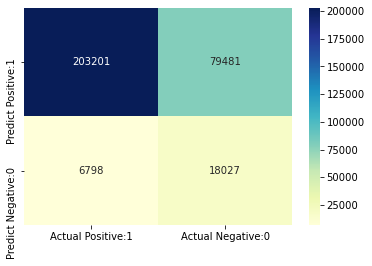

In [43]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [46]:
tp = []
tn = []
fp = []
fn = []

for i in np.arange(0.,1.,0.1):
    s = seuil(i, y_pred)
    cm = confusion_matrix(y, s)
    tp.append(cm[0,0])
    tn.append(cm[1,1])
    fp.append(cm[0,1])
    fn.append(cm[1,0])

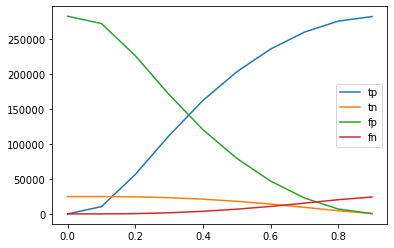

In [47]:
x = np.arange(0.,1.,0.1)

fig = plt.figure()
plt.plot(x, tp, label='tp')

plt.plot(x, tn, label='tn')

plt.plot(x, fp, label='fp')

plt.plot(x, fn, label='fn')

plt.legend()

In [56]:
def perte(k):
    s = seuil(k, y_pred)
    cm = confusion_matrix(y, s)
    perte = cm[0,1] + 10 * cm[1,0]
    return perte

In [81]:
P = [perte(k) for k in np.arange(0.,1.,0.05)]

In [82]:
P

[282682,
 281820,
 272319,
 253467,
 230285,
 206980,
 186594,
 169916,
 157800,
 150487,
 147461,
 149104,
 154286,
 163367,
 176546,
 191900,
 210338,
 227449,
 242406,
 248124]

In [83]:
np.argmin(P)

10

In [84]:
P[10]

147461

In [85]:
np.arange(0.,1.,0.05)[10]

0.5

In [110]:
test

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
307511,NaN,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0,1,0,1,0,0.121044,0.237342,67500.0,0.152300,0.036147
307512,NaN,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,0,0.247398,0.444409,49500.0,0.175455,0.077973
307513,NaN,0,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,0,0.222477,0.305308,101250.0,0.344578,0.105202
307514,NaN,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,1,0,0,1,0,0.133515,0.200000,78750.0,0.155614,0.031123
307515,NaN,0,1,1,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,0,0.168021,0.287770,60000.0,0.178150,0.051266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,0.002042,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,0.035792,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,0.018850,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [111]:
taux_remp(test)

TARGET                 0.000000
CODE_GENDER            1.000000
FLAG_OWN_CAR           1.000000
FLAG_OWN_REALTY        1.000000
CNT_CHILDREN           1.000000
                         ...   
DAYS_EMPLOYED_PERC     0.809741
INCOME_CREDIT_PERC     1.000000
INCOME_PER_PERSON      1.000000
ANNUITY_INCOME_PERC    0.999508
PAYMENT_RATE           0.999508
Length: 246, dtype: float64

In [112]:
test2 = test.fillna(X_fill.mean())

In [113]:
test2

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
307511,NaN,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0,1,0,1,0,0.121044,0.237342,67500.0,0.152300,0.036147
307512,NaN,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,0,0.247398,0.444409,49500.0,0.175455,0.077973
307513,NaN,0,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,0,0.222477,0.305308,101250.0,0.344578,0.105202
307514,NaN,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,1,0,0,1,0,0.133515,0.200000,78750.0,0.155614,0.031123
307515,NaN,0,1,1,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,0,0.168021,0.287770,60000.0,0.178150,0.051266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,0.002042,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,0.035792,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,0.018850,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [114]:
test2.to_csv('test.csv')

In [115]:
X_test = test2.drop(columns=['TARGET'])

In [116]:
X_test_s = scaler2.transform(X_test)

In [117]:
y_pred = clf4.predict_proba(X_test_s)

In [118]:
import pickle

In [119]:
pickle.dump(clf4, open('model.pkl', 'wb'))
model = pickle.load(open('model.pkl', 'rb'))

In [43]:
test2[test2['index'] ==0 ]

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
307511,0,100001,NaN,1,0,0,0,135000.0,568800.0,20560.5,...,0,1,0,1,0,0.121044,0.237342,67500.0,0.1523,0.036147
